# Self Driving Car

## Problem Definition
We are here building a minimal version of self driving car. Here, we have a front camera view. This will transfer input to the computer. Then Deep Learning algorithm in computer predicts the steering angle to avoid all sorts of collisions. Predicting steering angle can be thought of as a regression problem. We will feed images to Convolutional Neural Network and the label will be the steering angle in that image. Model will learn the steering angle from the as per the turns in the image and will finally predicts steering angle for unknown images.

## Dataset

Refer this: https://github.com/SullyChen/Autopilot-TensorFlow

There are total 45406 images in the dataset along with their steering angles. We will split the dataset into train and test in a ratio of 80:20 <b>sequentially</b>.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import pi
import cv2
import scipy.misc
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


## 1. Reading images from file

In [2]:
DATA_FOLDER = r"C:\Users\viral\Desktop\final_project\driving_dataset"
DATA_FILE = os.path.join(DATA_FOLDER, "data.txt")
x = []
y = []

train_batch_pointer = 0
test_batch_pointer = 0

In [3]:
with open(DATA_FILE) as f:
    for line in f:
        image_name, angle = line.split()
        
        image_path = os.path.join(DATA_FOLDER, image_name)
        x.append(image_path)
        
        angle_radians = float(angle) * (pi / 180)  #converting angle into radians
        y.append(angle_radians)
y = np.array(y)
print(str(len(x))+" "+str(len(y)))

45406 45406


In [4]:
split_ratio = int(len(x) * 0.8)

train_x = x[:split_ratio]
train_y = y[:split_ratio]

test_x = x[split_ratio:]
test_y = y[split_ratio:]

len(train_x), len(train_y), len(test_x), len(test_y)

(36324, 36324, 9082, 9082)

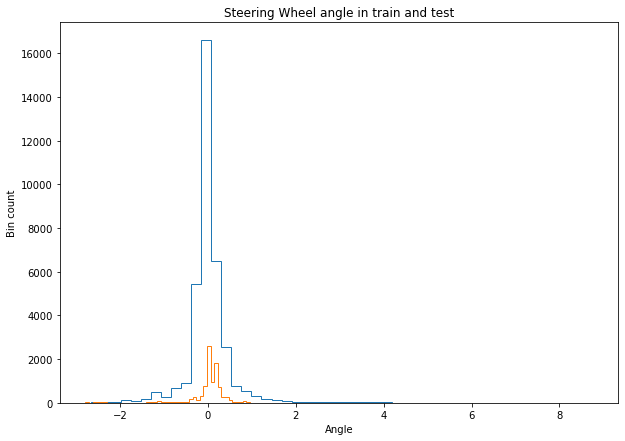

In [5]:
fig = plt.figure(figsize = (10, 7))
plt.hist(train_y, bins = 50, histtype = "step")
plt.hist(test_y, bins = 50, histtype = "step")
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.show()

Above histogram plot clearly shows that most of the values list on 0. This is obvious as well as most of the time car runs on straight road so therefore, steering wheel angle is 0 most of the time during driving.

## 2. Writing function for creating batch of images for training

In [6]:
def loadTrainBatch(batch_size):
    global train_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(train_x[(train_batch_pointer + i) % len(train_x)]) #here % len(train_x) is used to make sure that
        #"train_batch_pointer + i" should not cross the number of train images. As soon as the value of "train_batch_pointer" is
        #equal to number of train images then it will again start reading the train images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(train_y[(train_batch_pointer + i) % len(train_y)]) #appending corresponding labels
        
    train_batch_pointer += batch_size
        
    return x_result, y_result

In [7]:
def loadTestBatch(batch_size):
    global test_batch_pointer
    x_result = []
    y_result = []
    for i in range(batch_size):
        read_image = cv2.imread(test_x[(test_batch_pointer + i) % len(test_x)]) #here % len(test_x) is used to make sure that
        #"test_batch_pointer + i" should not cross the number of test images. As soon as the value of "test_batch_pointer" is
        #equal to number of test images then it will again start reading the test images from the beginning means from 0th
        #index onwards.
        read_image_road = read_image[-150:] #here, we are taking only the lower part of the images where there is a road in the
        #image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper
        #part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.
        read_image_resize = cv2.resize(read_image_road, (200, 66)) #After, resizing, each image will be of size (66, 200, 3). 
        #now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 
        #Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.
        read_image_final = read_image_resize/255.0  #here, we are normalizing the images
        
        x_result.append(read_image_final) #finally appending the image pixel matrix
        
        y_result.append(test_y[(test_batch_pointer + i) % len(test_y)]) #appending corresponding labels
        
    test_batch_pointer += batch_size
        
    return x_result, y_result

## 3. Making Model Architecture

In [8]:
def weightVariable(shape):
    initial = tf.truncated_normal(shape = shape, stddev = 0.1)
    return tf.Variable(initial) 

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def convolution(previous_input, filter_input, strides):
    return tf.nn.conv2d(previous_input, filter_input, strides = [1, strides, strides, 1], padding = "VALID")

In [9]:
x_input = tf.placeholder(tf.float32, shape = [None, 66, 200, 3], name = "Plc_1")
y_true = tf.placeholder(tf.float32, name = "Plc_2")

input_image = x_input

<img src = "Model_Architecture.png">

In [10]:
#Convolution Layers
#First convolution layer
W_Conv1 = weightVariable([5,5,3,24])
B_Conv1 = bias_variable([24])
Conv1 = tf.nn.relu(convolution(input_image, W_Conv1, 2) + B_Conv1)
#strides = 2
#Output size: 31*98*24

#Second convolution layer
W_Conv2 = weightVariable([5,5,24,36])
B_Conv2 = bias_variable([36])
Conv2 = tf.nn.relu(convolution(Conv1, W_Conv2, 2) + B_Conv2)
#strides = 2
#Output size: 14*47*36

#Third convolution layer
W_Conv3 = weightVariable([5,5,36,48])
B_Conv3 = bias_variable([48])
Conv3 = tf.nn.relu(convolution(Conv2, W_Conv3, 2) + B_Conv3)
#strides = 2
#Output size: 5*22*48

#Fourth convolution layer
W_Conv4 = weightVariable([3,3,48,64])
B_Conv4 = bias_variable([64])
Conv4 = tf.nn.relu(convolution(Conv3, W_Conv4, 1) + B_Conv4)
#strides = 1
#Output size: 3*20*64


#Fifth convolution layer
W_Conv5 = weightVariable([3,3,64,64])
B_Conv5 = bias_variable([64])
Conv5 = tf.nn.relu(convolution(Conv4, W_Conv5, 1) + B_Conv5)
#strides = 1
#Output size: 1*18*64

#Fully-Connected Dense Layers
keep_prob = tf.placeholder(tf.float32)
#First FC-Dense
#Input = 1*18*64 = 1152
W_FC1 = weightVariable([1152, 1164])
B_FC1 = bias_variable([1164])
FC1_Flatten = tf.reshape(Conv5, [-1, 1152]) #here, -1 indicates 1. It means that the shape of FC1_Flatten will be 1*1152
Output_FC1 = tf.nn.relu(tf.matmul(FC1_Flatten, W_FC1) + B_FC1) #so, here shape of FC1_Flatten is 1*1152 and shape of W_FC1 will
#be 1152*1164. Therefore, there will be a matrix multiplication of matrices: (1*1152) * (1152*1164) = (1*1164).
Output_FC1_drop = tf.nn.dropout(Output_FC1, keep_prob)

#Second FC-Dense
#Input = 1*1164 = 1164
W_FC2 = weightVariable([1164, 100])
B_FC2 = bias_variable([100])
Output_FC2 = tf.nn.relu(tf.matmul(Output_FC1_drop, W_FC2) + B_FC2) #so, here shape of Output_FC1_drop is 1*1164 and shape of 
#W_FC2 will be 1164*100. Therefore, there will be a matrix multiplication of matrices: (1*1164) * (1164*100) = (1*100).
Output_FC2_drop = tf.nn.dropout(Output_FC2, keep_prob)

#Third FC-Dense
#Input = 1*100 = 100
W_FC3 = weightVariable([100, 50])
B_FC3 = bias_variable([50])
Output_FC3 = tf.nn.relu(tf.matmul(Output_FC2_drop, W_FC3) + B_FC3) #so, here shape of Output_FC2_drop is 1*100 and shape of 
#W_FC3 will be 100*50. Therefore, there will be a matrix multiplication of matrices: (1*100) * (100*50) = (1*50).
Output_FC3_drop = tf.nn.dropout(Output_FC3, keep_prob)

#Fourth FC-Dense
#Input = 1*50 = 50
W_FC4 = weightVariable([50, 10])
B_FC4 = bias_variable([10])
Output_FC4 = tf.nn.relu(tf.matmul(Output_FC3_drop, W_FC4) + B_FC4) #so, here shape of Output_FC3_drop is 1*50 and shape of 
#W_FC4 will be 50*10. Therefore, there will be a matrix multiplication of matrices: (1*50) * (50*10) = (1*10).
Output_FC4_drop = tf.nn.dropout(Output_FC4, keep_prob)

#Final Output to one neuron with linear/identity function
#Input = 1*10 = 10
W_FC5 = weightVariable([10, 1])
B_FC5 = bias_variable([1])
y_predicted = tf.identity(tf.matmul(Output_FC4_drop, W_FC5) + B_FC5) #so, here shape of Output_FC4_drop is 1*10 and shape of 
#W_FC5 will be 10*1. Therefore, there will be a matrix multiplication of matrices: (1*10) * (10*1) = (1*1). Since, this is a 
#regression problem so we have applied identity fuction in the end. We can also apply "atan" function here. If computational
#power is available then the model should be tested with both identity and atan functions. In the end, that function should be
#considered which gives better result.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 4. Training the model

In [14]:
SAVEDIR = "../Saver/"
sess = tf.InteractiveSession()

L2NormConst = 0.001
train_vars = tf.trainable_variables() #it will return all the variables. Here, all the weights and biases are variables which
#are trainable.

loss = tf.reduce_mean(tf.square(tf.subtract(y_true, y_predicted))) + tf.add_n([tf.nn.l2_loss(w) for w in train_vars]) * L2NormConst
#since this is a regression problem so above loss is mean-squared-error loss
train_step = tf.train.AdamOptimizer(learning_rate = 10**-4).minimize(loss)
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()

epochs = 20
batch_size = 100
epoch_number, train_loss, test_loss,  = [], [], []
print(len(x)/batch_size)
for epoch in range(epochs):
    train_avg_loss = 0
    test_avg_loss = 0
    te_loss_old = 10000  #any big number can be given
    
    for i in range(int(len(x)/batch_size)):
        train_batch_x, train_batch_y = loadTrainBatch(batch_size)
        train_step.run(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 0.8})
        tr_loss = loss.eval(feed_dict = {x_input: train_batch_x, y_true: train_batch_y, keep_prob: 1.0})
        train_avg_loss += tr_loss / batch_size
    
        test_batch_x, test_batch_y = loadTestBatch(batch_size)
        te_loss_new = loss.eval(feed_dict = {x_input: test_batch_x, y_true: test_batch_y, keep_prob: 1.0})
        test_avg_loss += te_loss_new / batch_size
        
        if te_loss_new < te_loss_old:
            print("{}:Epoch: {}, Train_Loss: {}, Test_Loss: {} *".format(i+1,epoch+1, tr_loss, te_loss_new))
        else:
            print("{}:Epoch: {}, Train_Loss: {}, Test_Loss: {}".format(i+1,epoch+1, tr_loss, te_loss_new))
        te_loss_old = te_loss_new
        
        if (i+1) % batch_size == 0:
            if not os.path.exists(SAVEDIR):
                os.makedirs(SAVEDIR)
            save_path = os.path.join(SAVEDIR, "model.ckpt")
            saver.save(sess = sess, save_path = save_path)
            print("Model saved at location {} at epoch {}".format(save_path, epoch + 1))
        
    epoch_number.append(epoch)
    train_loss.append(train_avg_loss)
    test_loss.append(test_avg_loss)
    
#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
log_frame["Epoch"] = epoch_number
log_frame["Train Loss"] = train_loss
log_frame["Test Loss"] = test_loss
log_frame.to_csv(os.path.join(SAVEDIR, "log.csv"), index = False)


454.06
1:Epoch: 1, Train_Loss: 7.376565933227539, Test_Loss: 7.553927421569824 *
2:Epoch: 1, Train_Loss: 6.781405448913574, Test_Loss: 6.195307731628418 *
3:Epoch: 1, Train_Loss: 19.47220230102539, Test_Loss: 6.180707931518555 *
4:Epoch: 1, Train_Loss: 7.801889419555664, Test_Loss: 6.177549362182617 *
5:Epoch: 1, Train_Loss: 7.830547332763672, Test_Loss: 6.1470842361450195 *
6:Epoch: 1, Train_Loss: 9.521758079528809, Test_Loss: 6.161056041717529
7:Epoch: 1, Train_Loss: 6.195389270782471, Test_Loss: 6.257521152496338
8:Epoch: 1, Train_Loss: 6.1840739250183105, Test_Loss: 6.829221248626709
9:Epoch: 1, Train_Loss: 7.411583423614502, Test_Loss: 7.373073577880859
10:Epoch: 1, Train_Loss: 17.844032287597656, Test_Loss: 6.294064998626709 *
11:Epoch: 1, Train_Loss: 6.9775004386901855, Test_Loss: 6.24146032333374 *
12:Epoch: 1, Train_Loss: 6.137892246246338, Test_Loss: 6.108552932739258 *
13:Epoch: 1, Train_Loss: 11.470985412597656, Test_Loss: 6.103013515472412 *
14:Epoch: 1, Train_Loss: 7.3961

111:Epoch: 1, Train_Loss: 5.588990211486816, Test_Loss: 5.998798370361328
112:Epoch: 1, Train_Loss: 5.582352638244629, Test_Loss: 5.713013172149658 *
113:Epoch: 1, Train_Loss: 5.578407287597656, Test_Loss: 5.706211090087891 *
114:Epoch: 1, Train_Loss: 5.572708606719971, Test_Loss: 5.587041854858398 *
115:Epoch: 1, Train_Loss: 5.567555904388428, Test_Loss: 5.584359169006348 *
116:Epoch: 1, Train_Loss: 5.562981605529785, Test_Loss: 5.582019329071045 *
117:Epoch: 1, Train_Loss: 5.62104606628418, Test_Loss: 5.576471328735352 *
118:Epoch: 1, Train_Loss: 5.626044750213623, Test_Loss: 5.614011287689209
119:Epoch: 1, Train_Loss: 5.62944221496582, Test_Loss: 10.645492553710938
120:Epoch: 1, Train_Loss: 5.6053385734558105, Test_Loss: 5.730656623840332 *
121:Epoch: 1, Train_Loss: 5.540542125701904, Test_Loss: 5.556214332580566 *
122:Epoch: 1, Train_Loss: 5.684439182281494, Test_Loss: 5.5454535484313965 *
123:Epoch: 1, Train_Loss: 5.783184051513672, Test_Loss: 5.554389476776123
124:Epoch: 1, Train

220:Epoch: 1, Train_Loss: 5.08554220199585, Test_Loss: 5.08575963973999 *
221:Epoch: 1, Train_Loss: 5.081219673156738, Test_Loss: 5.083554744720459 *
222:Epoch: 1, Train_Loss: 5.077425956726074, Test_Loss: 5.117257595062256
223:Epoch: 1, Train_Loss: 5.0723700523376465, Test_Loss: 5.120200157165527
224:Epoch: 1, Train_Loss: 5.0840582847595215, Test_Loss: 5.0867018699646 *
225:Epoch: 1, Train_Loss: 5.079495429992676, Test_Loss: 5.063966274261475 *
226:Epoch: 1, Train_Loss: 5.076505661010742, Test_Loss: 5.060523986816406 *
227:Epoch: 1, Train_Loss: 5.07558536529541, Test_Loss: 5.055707931518555 *
228:Epoch: 1, Train_Loss: 5.066937446594238, Test_Loss: 5.051118850708008 *
229:Epoch: 1, Train_Loss: 5.05433464050293, Test_Loss: 5.046769618988037 *
230:Epoch: 1, Train_Loss: 5.043471813201904, Test_Loss: 5.043356895446777 *
231:Epoch: 1, Train_Loss: 5.037475109100342, Test_Loss: 5.037748336791992 *
232:Epoch: 1, Train_Loss: 5.063601493835449, Test_Loss: 5.034241676330566 *
233:Epoch: 1, Train_

329:Epoch: 1, Train_Loss: 4.649383068084717, Test_Loss: 4.646263599395752 *
330:Epoch: 1, Train_Loss: 4.6744279861450195, Test_Loss: 4.667341232299805
331:Epoch: 1, Train_Loss: 4.68637228012085, Test_Loss: 4.683467864990234
332:Epoch: 1, Train_Loss: 5.120826721191406, Test_Loss: 8.0895357131958
333:Epoch: 1, Train_Loss: 5.073978424072266, Test_Loss: 6.585526466369629 *
334:Epoch: 1, Train_Loss: 5.174041748046875, Test_Loss: 4.629127502441406 *
335:Epoch: 1, Train_Loss: 5.5649614334106445, Test_Loss: 4.629449367523193
336:Epoch: 1, Train_Loss: 4.799297332763672, Test_Loss: 4.687580108642578
337:Epoch: 1, Train_Loss: 5.2161383628845215, Test_Loss: 4.693064212799072
338:Epoch: 1, Train_Loss: 4.82344388961792, Test_Loss: 4.648045539855957 *
339:Epoch: 1, Train_Loss: 4.617072582244873, Test_Loss: 4.6692352294921875
340:Epoch: 1, Train_Loss: 4.628212928771973, Test_Loss: 4.691802024841309
341:Epoch: 1, Train_Loss: 4.699524402618408, Test_Loss: 4.605859756469727 *
342:Epoch: 1, Train_Loss: 4.

437:Epoch: 1, Train_Loss: 4.305482864379883, Test_Loss: 4.379343032836914
438:Epoch: 1, Train_Loss: 4.2987260818481445, Test_Loss: 4.3135480880737305 *
439:Epoch: 1, Train_Loss: 4.282912731170654, Test_Loss: 4.465814590454102
440:Epoch: 1, Train_Loss: 4.281124114990234, Test_Loss: 4.385811805725098 *
441:Epoch: 1, Train_Loss: 4.2941813468933105, Test_Loss: 4.280174255371094 *
442:Epoch: 1, Train_Loss: 4.292111396789551, Test_Loss: 4.2671966552734375 *
443:Epoch: 1, Train_Loss: 4.270833492279053, Test_Loss: 4.264869213104248 *
444:Epoch: 1, Train_Loss: 4.268433094024658, Test_Loss: 4.260959148406982 *
445:Epoch: 1, Train_Loss: 4.265833854675293, Test_Loss: 4.257707118988037 *
446:Epoch: 1, Train_Loss: 4.2813639640808105, Test_Loss: 4.254848003387451 *
447:Epoch: 1, Train_Loss: 4.252103328704834, Test_Loss: 4.251359462738037 *
448:Epoch: 1, Train_Loss: 4.251935005187988, Test_Loss: 4.247280597686768 *
449:Epoch: 1, Train_Loss: 4.271884441375732, Test_Loss: 4.2525434494018555
450:Epoch: 1

93:Epoch: 2, Train_Loss: 3.9530513286590576, Test_Loss: 4.552103042602539
94:Epoch: 2, Train_Loss: 3.948925018310547, Test_Loss: 4.193178653717041 *
95:Epoch: 2, Train_Loss: 3.9463653564453125, Test_Loss: 4.020932197570801 *
96:Epoch: 2, Train_Loss: 3.958345413208008, Test_Loss: 3.9827487468719482 *
97:Epoch: 2, Train_Loss: 3.94563889503479, Test_Loss: 3.9545555114746094 *
98:Epoch: 2, Train_Loss: 3.9383060932159424, Test_Loss: 4.056698322296143
99:Epoch: 2, Train_Loss: 3.9355697631835938, Test_Loss: 4.854087829589844
100:Epoch: 2, Train_Loss: 3.947550058364868, Test_Loss: 5.3762078285217285
Model saved at location ../Saver/model.ckpt at epoch 2
101:Epoch: 2, Train_Loss: 4.0188422203063965, Test_Loss: 4.0666728019714355 *
102:Epoch: 2, Train_Loss: 3.9566969871520996, Test_Loss: 4.029537200927734 *
103:Epoch: 2, Train_Loss: 3.956146240234375, Test_Loss: 3.9243500232696533 *
104:Epoch: 2, Train_Loss: 3.9211859703063965, Test_Loss: 3.930579662322998
105:Epoch: 2, Train_Loss: 3.95518636703

200:Epoch: 2, Train_Loss: 3.6699724197387695, Test_Loss: 3.674901247024536 *
Model saved at location ../Saver/model.ckpt at epoch 2
201:Epoch: 2, Train_Loss: 3.667337417602539, Test_Loss: 3.78981351852417
202:Epoch: 2, Train_Loss: 3.674225091934204, Test_Loss: 4.080153942108154
203:Epoch: 2, Train_Loss: 3.745617151260376, Test_Loss: 3.8589024543762207 *
204:Epoch: 2, Train_Loss: 3.7376577854156494, Test_Loss: 3.718104839324951 *
205:Epoch: 2, Train_Loss: 3.7649714946746826, Test_Loss: 3.6678802967071533 *
206:Epoch: 2, Train_Loss: 3.8437986373901367, Test_Loss: 3.6655027866363525 *
207:Epoch: 2, Train_Loss: 4.0595011711120605, Test_Loss: 3.663010358810425 *
208:Epoch: 2, Train_Loss: 3.662140369415283, Test_Loss: 3.661262273788452 *
209:Epoch: 2, Train_Loss: 3.702359914779663, Test_Loss: 3.7895548343658447
210:Epoch: 2, Train_Loss: 3.9563043117523193, Test_Loss: 8.840782165527344
211:Epoch: 2, Train_Loss: 4.239605903625488, Test_Loss: 3.7529783248901367 *
212:Epoch: 2, Train_Loss: 3.710

307:Epoch: 2, Train_Loss: 3.418048620223999, Test_Loss: 3.421013355255127 *
308:Epoch: 2, Train_Loss: 3.417748212814331, Test_Loss: 3.4279730319976807
309:Epoch: 2, Train_Loss: 3.4129953384399414, Test_Loss: 3.42258358001709 *
310:Epoch: 2, Train_Loss: 3.410890817642212, Test_Loss: 3.4204344749450684 *
311:Epoch: 2, Train_Loss: 3.409148931503296, Test_Loss: 3.4159061908721924 *
312:Epoch: 2, Train_Loss: 3.4080660343170166, Test_Loss: 3.4176220893859863
313:Epoch: 2, Train_Loss: 3.4220712184906006, Test_Loss: 3.4201927185058594
314:Epoch: 2, Train_Loss: 3.4283647537231445, Test_Loss: 3.419828414916992 *
315:Epoch: 2, Train_Loss: 3.4131484031677246, Test_Loss: 3.4124817848205566 *
316:Epoch: 2, Train_Loss: 3.405367612838745, Test_Loss: 3.403529167175293 *
317:Epoch: 2, Train_Loss: 7.033933639526367, Test_Loss: 3.400850772857666 *
318:Epoch: 2, Train_Loss: 9.151585578918457, Test_Loss: 3.3993613719940186 *
319:Epoch: 2, Train_Loss: 3.420506715774536, Test_Loss: 3.3988986015319824 *
320:Ep

414:Epoch: 2, Train_Loss: 3.213930606842041, Test_Loss: 3.2049691677093506
415:Epoch: 2, Train_Loss: 3.3655056953430176, Test_Loss: 3.199686288833618 *
416:Epoch: 2, Train_Loss: 3.3226139545440674, Test_Loss: 3.1986284255981445 *
417:Epoch: 2, Train_Loss: 3.4739999771118164, Test_Loss: 3.195345401763916 *
418:Epoch: 2, Train_Loss: 3.2035958766937256, Test_Loss: 3.1942250728607178 *
419:Epoch: 2, Train_Loss: 3.725696563720703, Test_Loss: 3.191591501235962 *
420:Epoch: 2, Train_Loss: 5.903409004211426, Test_Loss: 3.1888787746429443 *
421:Epoch: 2, Train_Loss: 3.2339370250701904, Test_Loss: 3.2314822673797607
422:Epoch: 2, Train_Loss: 3.2280802726745605, Test_Loss: 3.216862440109253 *
423:Epoch: 2, Train_Loss: 3.226101875305176, Test_Loss: 7.288804054260254
424:Epoch: 2, Train_Loss: 3.2283051013946533, Test_Loss: 4.665893077850342 *
425:Epoch: 2, Train_Loss: 3.17883563041687, Test_Loss: 3.1796274185180664 *
426:Epoch: 2, Train_Loss: 3.1796786785125732, Test_Loss: 3.1853203773498535
427:Ep

69:Epoch: 3, Train_Loss: 3.1453421115875244, Test_Loss: 2.99706768989563 *
70:Epoch: 3, Train_Loss: 3.018073558807373, Test_Loss: 3.035757541656494
71:Epoch: 3, Train_Loss: 2.9950904846191406, Test_Loss: 3.0088255405426025 *
72:Epoch: 3, Train_Loss: 3.0214133262634277, Test_Loss: 3.001194953918457 *
73:Epoch: 3, Train_Loss: 3.039322853088379, Test_Loss: 3.0018625259399414
74:Epoch: 3, Train_Loss: 3.0017993450164795, Test_Loss: 3.1258511543273926
75:Epoch: 3, Train_Loss: 2.999856948852539, Test_Loss: 3.0202419757843018 *
76:Epoch: 3, Train_Loss: 4.163471698760986, Test_Loss: 3.1022796630859375
77:Epoch: 3, Train_Loss: 4.402400016784668, Test_Loss: 3.037834882736206 *
78:Epoch: 3, Train_Loss: 3.2602007389068604, Test_Loss: 3.0241098403930664 *
79:Epoch: 3, Train_Loss: 3.0647642612457275, Test_Loss: 3.0011746883392334 *
80:Epoch: 3, Train_Loss: 4.426328659057617, Test_Loss: 2.9981606006622314 *
81:Epoch: 3, Train_Loss: 5.003405570983887, Test_Loss: 2.9946866035461426 *
82:Epoch: 3, Train_

177:Epoch: 3, Train_Loss: 3.62490177154541, Test_Loss: 2.8175923824310303 *
178:Epoch: 3, Train_Loss: 3.056535482406616, Test_Loss: 2.8165078163146973 *
179:Epoch: 3, Train_Loss: 2.819833755493164, Test_Loss: 2.8352091312408447
180:Epoch: 3, Train_Loss: 2.813953399658203, Test_Loss: 2.820277690887451 *
181:Epoch: 3, Train_Loss: 2.813448667526245, Test_Loss: 2.8264284133911133
182:Epoch: 3, Train_Loss: 2.8455145359039307, Test_Loss: 2.8320071697235107
183:Epoch: 3, Train_Loss: 2.817532777786255, Test_Loss: 3.08422589302063
184:Epoch: 3, Train_Loss: 2.825840711593628, Test_Loss: 3.306994676589966
185:Epoch: 3, Train_Loss: 20.06403923034668, Test_Loss: 3.0409352779388428 *
186:Epoch: 3, Train_Loss: 2.8063952922821045, Test_Loss: 2.8764595985412598 *
187:Epoch: 3, Train_Loss: 4.784481525421143, Test_Loss: 2.838062286376953 *
188:Epoch: 3, Train_Loss: 4.841809272766113, Test_Loss: 2.803462266921997 *
189:Epoch: 3, Train_Loss: 2.8028578758239746, Test_Loss: 2.842987298965454
190:Epoch: 3, Tr

285:Epoch: 3, Train_Loss: 2.6693239212036133, Test_Loss: 2.6690175533294678 *
286:Epoch: 3, Train_Loss: 2.667701244354248, Test_Loss: 2.6764636039733887
287:Epoch: 3, Train_Loss: 2.665843963623047, Test_Loss: 2.6710474491119385 *
288:Epoch: 3, Train_Loss: 4.207372188568115, Test_Loss: 2.6904613971710205
289:Epoch: 3, Train_Loss: 6.075211524963379, Test_Loss: 2.7314133644104004
290:Epoch: 3, Train_Loss: 2.657797336578369, Test_Loss: 2.669186592102051 *
291:Epoch: 3, Train_Loss: 2.674699544906616, Test_Loss: 2.6703503131866455
292:Epoch: 3, Train_Loss: 2.6692850589752197, Test_Loss: 2.7583982944488525
293:Epoch: 3, Train_Loss: 2.6514103412628174, Test_Loss: 3.046435832977295
294:Epoch: 3, Train_Loss: 2.6508326530456543, Test_Loss: 2.8716888427734375 *
295:Epoch: 3, Train_Loss: 2.6493868827819824, Test_Loss: 2.6659023761749268 *
296:Epoch: 3, Train_Loss: 2.6486971378326416, Test_Loss: 2.6532506942749023 *
297:Epoch: 3, Train_Loss: 2.646303415298462, Test_Loss: 2.6524102687835693 *
298:Epo

392:Epoch: 3, Train_Loss: 2.57226824760437, Test_Loss: 6.882898807525635
393:Epoch: 3, Train_Loss: 2.585327625274658, Test_Loss: 2.538328170776367 *
394:Epoch: 3, Train_Loss: 2.561751127243042, Test_Loss: 2.525355100631714 *
395:Epoch: 3, Train_Loss: 2.5663371086120605, Test_Loss: 2.5235509872436523 *
396:Epoch: 3, Train_Loss: 2.547530174255371, Test_Loss: 2.527188777923584
397:Epoch: 3, Train_Loss: 2.5303750038146973, Test_Loss: 2.521353006362915 *
398:Epoch: 3, Train_Loss: 2.638497829437256, Test_Loss: 2.5199501514434814 *
399:Epoch: 3, Train_Loss: 2.7235491275787354, Test_Loss: 2.518550157546997 *
400:Epoch: 3, Train_Loss: 2.5152907371520996, Test_Loss: 2.515953540802002 *
Model saved at location ../Saver/model.ckpt at epoch 3
401:Epoch: 3, Train_Loss: 2.5460190773010254, Test_Loss: 2.5156607627868652 *
402:Epoch: 3, Train_Loss: 2.511951446533203, Test_Loss: 2.5124824047088623 *
403:Epoch: 3, Train_Loss: 2.5102179050445557, Test_Loss: 2.5159153938293457
404:Epoch: 3, Train_Loss: 2.5

46:Epoch: 4, Train_Loss: 2.632443428039551, Test_Loss: 2.397346019744873 *
47:Epoch: 4, Train_Loss: 2.5187008380889893, Test_Loss: 2.3976051807403564
48:Epoch: 4, Train_Loss: 2.416443347930908, Test_Loss: 2.396422863006592 *
49:Epoch: 4, Train_Loss: 2.446329355239868, Test_Loss: 2.395629405975342 *
50:Epoch: 4, Train_Loss: 2.6005094051361084, Test_Loss: 2.3984899520874023
51:Epoch: 4, Train_Loss: 2.583216667175293, Test_Loss: 2.4095041751861572
52:Epoch: 4, Train_Loss: 2.400545120239258, Test_Loss: 2.397493839263916 *
53:Epoch: 4, Train_Loss: 2.5174803733825684, Test_Loss: 2.3972058296203613 *
54:Epoch: 4, Train_Loss: 2.6039657592773438, Test_Loss: 2.389768362045288 *
55:Epoch: 4, Train_Loss: 2.4324240684509277, Test_Loss: 2.391400098800659
56:Epoch: 4, Train_Loss: 2.4513535499572754, Test_Loss: 2.3909432888031006 *
57:Epoch: 4, Train_Loss: 2.39328670501709, Test_Loss: 2.385070562362671 *
58:Epoch: 4, Train_Loss: 2.422637939453125, Test_Loss: 2.449876546859741
59:Epoch: 4, Train_Loss: 

154:Epoch: 4, Train_Loss: 2.306450366973877, Test_Loss: 2.300152540206909
155:Epoch: 4, Train_Loss: 2.350856304168701, Test_Loss: 2.31657338142395
156:Epoch: 4, Train_Loss: 2.305250644683838, Test_Loss: 2.3171072006225586
157:Epoch: 4, Train_Loss: 2.284602403640747, Test_Loss: 2.284658432006836 *
158:Epoch: 4, Train_Loss: 2.2835326194763184, Test_Loss: 2.432243585586548
159:Epoch: 4, Train_Loss: 2.281831741333008, Test_Loss: 2.3562653064727783 *
160:Epoch: 4, Train_Loss: 2.509719133377075, Test_Loss: 2.2772231101989746 *
161:Epoch: 4, Train_Loss: 7.703246116638184, Test_Loss: 2.3445425033569336
162:Epoch: 4, Train_Loss: 2.2885916233062744, Test_Loss: 2.2781155109405518 *
163:Epoch: 4, Train_Loss: 2.308889865875244, Test_Loss: 2.3006157875061035
164:Epoch: 4, Train_Loss: 2.3281567096710205, Test_Loss: 2.2895421981811523 *
165:Epoch: 4, Train_Loss: 2.3122334480285645, Test_Loss: 2.318686008453369
166:Epoch: 4, Train_Loss: 2.2937378883361816, Test_Loss: 2.3437089920043945
167:Epoch: 4, Tr

262:Epoch: 4, Train_Loss: 2.1779754161834717, Test_Loss: 2.1982431411743164 *
263:Epoch: 4, Train_Loss: 2.1774048805236816, Test_Loss: 2.199251890182495
264:Epoch: 4, Train_Loss: 2.1770167350769043, Test_Loss: 2.1996171474456787
265:Epoch: 4, Train_Loss: 2.1757915019989014, Test_Loss: 2.1989238262176514 *
266:Epoch: 4, Train_Loss: 2.1755197048187256, Test_Loss: 2.1983184814453125 *
267:Epoch: 4, Train_Loss: 2.174459457397461, Test_Loss: 2.2045884132385254
268:Epoch: 4, Train_Loss: 2.1729633808135986, Test_Loss: 2.20161771774292 *
269:Epoch: 4, Train_Loss: 2.1732585430145264, Test_Loss: 2.2043440341949463
270:Epoch: 4, Train_Loss: 2.183316946029663, Test_Loss: 2.1756582260131836 *
271:Epoch: 4, Train_Loss: 2.18064546585083, Test_Loss: 2.193479299545288
272:Epoch: 4, Train_Loss: 2.1802384853363037, Test_Loss: 2.254669189453125
273:Epoch: 4, Train_Loss: 2.186903715133667, Test_Loss: 2.1833715438842773 *
274:Epoch: 4, Train_Loss: 2.175309419631958, Test_Loss: 2.587284803390503
275:Epoch: 4

369:Epoch: 4, Train_Loss: 2.4995620250701904, Test_Loss: 2.1109442710876465 *
370:Epoch: 4, Train_Loss: 2.206753969192505, Test_Loss: 2.100398302078247 *
371:Epoch: 4, Train_Loss: 2.1538188457489014, Test_Loss: 2.275759220123291
372:Epoch: 4, Train_Loss: 2.3566861152648926, Test_Loss: 3.30747652053833
373:Epoch: 4, Train_Loss: 2.4431252479553223, Test_Loss: 2.972508668899536 *
374:Epoch: 4, Train_Loss: 2.5502991676330566, Test_Loss: 2.135115623474121 *
375:Epoch: 4, Train_Loss: 2.2683358192443848, Test_Loss: 2.134382724761963 *
376:Epoch: 4, Train_Loss: 2.159172773361206, Test_Loss: 2.079812526702881 *
377:Epoch: 4, Train_Loss: 2.2038841247558594, Test_Loss: 2.0795934200286865 *
378:Epoch: 4, Train_Loss: 2.1378912925720215, Test_Loss: 2.0849757194519043
379:Epoch: 4, Train_Loss: 2.090916633605957, Test_Loss: 2.0913546085357666
380:Epoch: 4, Train_Loss: 2.0733799934387207, Test_Loss: 2.129613161087036
381:Epoch: 4, Train_Loss: 2.0737855434417725, Test_Loss: 2.0761971473693848 *
382:Epoc

23:Epoch: 5, Train_Loss: 2.0081541538238525, Test_Loss: 2.0058095455169678 *
24:Epoch: 5, Train_Loss: 2.0243067741394043, Test_Loss: 2.0118632316589355
25:Epoch: 5, Train_Loss: 1.9963829517364502, Test_Loss: 2.0089595317840576 *
26:Epoch: 5, Train_Loss: 2.030759334564209, Test_Loss: 2.0039846897125244 *
27:Epoch: 5, Train_Loss: 2.0592470169067383, Test_Loss: 1.9967026710510254 *
28:Epoch: 5, Train_Loss: 2.043267250061035, Test_Loss: 3.7162764072418213
29:Epoch: 5, Train_Loss: 2.0007662773132324, Test_Loss: 6.229696273803711
30:Epoch: 5, Train_Loss: 1.994300127029419, Test_Loss: 2.0272390842437744 *
31:Epoch: 5, Train_Loss: 1.9918750524520874, Test_Loss: 2.0153257846832275 *
32:Epoch: 5, Train_Loss: 1.9873645305633545, Test_Loss: 2.0039780139923096 *
33:Epoch: 5, Train_Loss: 1.9871093034744263, Test_Loss: 1.9900556802749634 *
34:Epoch: 5, Train_Loss: 1.9849162101745605, Test_Loss: 2.014556646347046
35:Epoch: 5, Train_Loss: 1.9843422174453735, Test_Loss: 2.0194480419158936
36:Epoch: 5, T

131:Epoch: 5, Train_Loss: 1.9181946516036987, Test_Loss: 1.9220788478851318
132:Epoch: 5, Train_Loss: 1.9154373407363892, Test_Loss: 1.9331716299057007
133:Epoch: 5, Train_Loss: 1.911589503288269, Test_Loss: 1.9243687391281128 *
134:Epoch: 5, Train_Loss: 1.9118690490722656, Test_Loss: 1.9161419868469238 *
135:Epoch: 5, Train_Loss: 1.9183741807937622, Test_Loss: 1.9092763662338257 *
136:Epoch: 5, Train_Loss: 2.042454481124878, Test_Loss: 1.9113153219223022
137:Epoch: 5, Train_Loss: 2.081397294998169, Test_Loss: 1.9090044498443604 *
138:Epoch: 5, Train_Loss: 2.094770908355713, Test_Loss: 1.9092837572097778
139:Epoch: 5, Train_Loss: 1.9557678699493408, Test_Loss: 1.9122374057769775
140:Epoch: 5, Train_Loss: 2.061645030975342, Test_Loss: 1.9077492952346802 *
141:Epoch: 5, Train_Loss: 2.052785873413086, Test_Loss: 1.908090591430664
142:Epoch: 5, Train_Loss: 1.9443044662475586, Test_Loss: 1.913313388824463
143:Epoch: 5, Train_Loss: 2.0784213542938232, Test_Loss: 1.9064940214157104 *
144:Epoc

238:Epoch: 5, Train_Loss: 1.8766919374465942, Test_Loss: 1.8382092714309692
239:Epoch: 5, Train_Loss: 1.8343571424484253, Test_Loss: 1.8386482000350952
240:Epoch: 5, Train_Loss: 1.8677973747253418, Test_Loss: 1.8897662162780762
241:Epoch: 5, Train_Loss: 1.8347824811935425, Test_Loss: 1.9685674905776978
242:Epoch: 5, Train_Loss: 1.8518368005752563, Test_Loss: 7.323266983032227
243:Epoch: 5, Train_Loss: 1.8338605165481567, Test_Loss: 1.8525069952011108 *
244:Epoch: 5, Train_Loss: 1.8564331531524658, Test_Loss: 1.8309663534164429 *
245:Epoch: 5, Train_Loss: 2.0547683238983154, Test_Loss: 1.8628252744674683
246:Epoch: 5, Train_Loss: 5.496124267578125, Test_Loss: 1.8847672939300537
247:Epoch: 5, Train_Loss: 3.401902675628662, Test_Loss: 1.8813434839248657 *
248:Epoch: 5, Train_Loss: 1.848633885383606, Test_Loss: 1.8320677280426025 *
249:Epoch: 5, Train_Loss: 1.8301012516021729, Test_Loss: 1.9396992921829224
250:Epoch: 5, Train_Loss: 1.980893850326538, Test_Loss: 1.8667116165161133 *
251:Epo

345:Epoch: 5, Train_Loss: 3.406492233276367, Test_Loss: 1.793546438217163 *
346:Epoch: 5, Train_Loss: 2.4080028533935547, Test_Loss: 1.8423880338668823
347:Epoch: 5, Train_Loss: 2.385998249053955, Test_Loss: 1.7718585729599 *
348:Epoch: 5, Train_Loss: 1.8974958658218384, Test_Loss: 1.8497084379196167
349:Epoch: 5, Train_Loss: 1.780259609222412, Test_Loss: 1.7672898769378662 *
350:Epoch: 5, Train_Loss: 1.8988972902297974, Test_Loss: 1.8472932577133179
351:Epoch: 5, Train_Loss: 2.7092909812927246, Test_Loss: 1.8781660795211792
352:Epoch: 5, Train_Loss: 2.5791168212890625, Test_Loss: 1.7662714719772339 *
353:Epoch: 5, Train_Loss: 1.8021512031555176, Test_Loss: 1.7806918621063232
354:Epoch: 5, Train_Loss: 1.8227325677871704, Test_Loss: 1.7894067764282227
355:Epoch: 5, Train_Loss: 1.8526734113693237, Test_Loss: 1.8026258945465088
356:Epoch: 5, Train_Loss: 2.0762221813201904, Test_Loss: 1.7991065979003906 *
357:Epoch: 5, Train_Loss: 1.9491788148880005, Test_Loss: 1.7938504219055176 *
358:Epo

452:Epoch: 5, Train_Loss: 1.6968368291854858, Test_Loss: 1.7040776014328003
453:Epoch: 5, Train_Loss: 1.698372483253479, Test_Loss: 1.7089661359786987
454:Epoch: 5, Train_Loss: 1.7356693744659424, Test_Loss: 1.7430129051208496
1:Epoch: 6, Train_Loss: 1.8062827587127686, Test_Loss: 1.7117985486984253 *
2:Epoch: 6, Train_Loss: 1.7663754224777222, Test_Loss: 2.1650352478027344
3:Epoch: 6, Train_Loss: 1.7693419456481934, Test_Loss: 2.1536309719085693 *
4:Epoch: 6, Train_Loss: 1.7277565002441406, Test_Loss: 1.8135079145431519 *
5:Epoch: 6, Train_Loss: 1.7717441320419312, Test_Loss: 1.7112023830413818 *
6:Epoch: 6, Train_Loss: 1.7508397102355957, Test_Loss: 1.707574486732483 *
7:Epoch: 6, Train_Loss: 1.734131932258606, Test_Loss: 1.7387771606445312
8:Epoch: 6, Train_Loss: 1.775603175163269, Test_Loss: 2.0055179595947266
9:Epoch: 6, Train_Loss: 1.7348514795303345, Test_Loss: 3.135166645050049
10:Epoch: 6, Train_Loss: 1.704530954360962, Test_Loss: 2.5641403198242188 *
11:Epoch: 6, Train_Loss: 

106:Epoch: 6, Train_Loss: 1.669939637184143, Test_Loss: 1.6388112306594849
107:Epoch: 6, Train_Loss: 1.6314142942428589, Test_Loss: 1.6653006076812744
108:Epoch: 6, Train_Loss: 1.6510443687438965, Test_Loss: 1.694218397140503
109:Epoch: 6, Train_Loss: 1.6641671657562256, Test_Loss: 1.6313508749008179 *
110:Epoch: 6, Train_Loss: 1.7160636186599731, Test_Loss: 1.693656325340271
111:Epoch: 6, Train_Loss: 1.7307673692703247, Test_Loss: 1.7847490310668945
112:Epoch: 6, Train_Loss: 1.7166423797607422, Test_Loss: 1.9416308403015137
113:Epoch: 6, Train_Loss: 1.667218804359436, Test_Loss: 1.825040340423584 *
114:Epoch: 6, Train_Loss: 1.6284456253051758, Test_Loss: 1.6316453218460083 *
115:Epoch: 6, Train_Loss: 1.6549642086029053, Test_Loss: 1.6283743381500244 *
116:Epoch: 6, Train_Loss: 1.625545620918274, Test_Loss: 1.6277587413787842 *
117:Epoch: 6, Train_Loss: 1.633374571800232, Test_Loss: 1.6271287202835083 *
118:Epoch: 6, Train_Loss: 1.6346781253814697, Test_Loss: 1.635812520980835
119:Epoc

213:Epoch: 6, Train_Loss: 1.5882583856582642, Test_Loss: 1.5776784420013428 *
214:Epoch: 6, Train_Loss: 1.8338260650634766, Test_Loss: 1.576297402381897 *
215:Epoch: 6, Train_Loss: 2.115628957748413, Test_Loss: 1.5752490758895874 *
216:Epoch: 6, Train_Loss: 1.8757648468017578, Test_Loss: 1.60000479221344
217:Epoch: 6, Train_Loss: 1.593514084815979, Test_Loss: 1.6172584295272827
218:Epoch: 6, Train_Loss: 1.5879216194152832, Test_Loss: 1.5815293788909912 *
219:Epoch: 6, Train_Loss: 1.6166062355041504, Test_Loss: 1.5867959260940552
220:Epoch: 6, Train_Loss: 2.868455171585083, Test_Loss: 1.5913258790969849
221:Epoch: 6, Train_Loss: 2.2435660362243652, Test_Loss: 1.6032222509384155
222:Epoch: 6, Train_Loss: 1.5779998302459717, Test_Loss: 1.609993577003479
223:Epoch: 6, Train_Loss: 1.5948697328567505, Test_Loss: 1.5679434537887573 *
224:Epoch: 6, Train_Loss: 1.5679056644439697, Test_Loss: 1.5745655298233032
225:Epoch: 6, Train_Loss: 1.7184076309204102, Test_Loss: 1.5857311487197876
226:Epoch

320:Epoch: 6, Train_Loss: 1.5271930694580078, Test_Loss: 1.5225111246109009
321:Epoch: 6, Train_Loss: 1.554455280303955, Test_Loss: 1.544657588005066
322:Epoch: 6, Train_Loss: 1.5343817472457886, Test_Loss: 1.5497164726257324
323:Epoch: 6, Train_Loss: 1.5165973901748657, Test_Loss: 1.5633630752563477
324:Epoch: 6, Train_Loss: 1.5403858423233032, Test_Loss: 1.554445505142212 *
325:Epoch: 6, Train_Loss: 1.5967795848846436, Test_Loss: 1.5493879318237305 *
326:Epoch: 6, Train_Loss: 1.7561070919036865, Test_Loss: 1.5315723419189453 *
327:Epoch: 6, Train_Loss: 1.7335734367370605, Test_Loss: 1.5333034992218018
328:Epoch: 6, Train_Loss: 1.642760992050171, Test_Loss: 1.5325146913528442 *
329:Epoch: 6, Train_Loss: 1.5507797002792358, Test_Loss: 1.5323609113693237 *
330:Epoch: 6, Train_Loss: 1.6505482196807861, Test_Loss: 1.5338181257247925
331:Epoch: 6, Train_Loss: 1.6270920038223267, Test_Loss: 1.5816913843154907
332:Epoch: 6, Train_Loss: 1.6737560033798218, Test_Loss: 2.038038969039917
333:Epo

427:Epoch: 6, Train_Loss: 1.5343681573867798, Test_Loss: 1.511780858039856
428:Epoch: 6, Train_Loss: 1.5808838605880737, Test_Loss: 1.5247005224227905
429:Epoch: 6, Train_Loss: 1.5688714981079102, Test_Loss: 1.5242547988891602 *
430:Epoch: 6, Train_Loss: 1.5392566919326782, Test_Loss: 1.4830946922302246 *
431:Epoch: 6, Train_Loss: 1.5546170473098755, Test_Loss: 1.571758508682251
432:Epoch: 6, Train_Loss: 1.4875457286834717, Test_Loss: 1.4658979177474976 *
433:Epoch: 6, Train_Loss: 1.488853931427002, Test_Loss: 1.4676018953323364
434:Epoch: 6, Train_Loss: 1.4665677547454834, Test_Loss: 1.4861074686050415
435:Epoch: 6, Train_Loss: 1.4955518245697021, Test_Loss: 1.4713419675827026 *
436:Epoch: 6, Train_Loss: 1.4761327505111694, Test_Loss: 1.4630100727081299 *
437:Epoch: 6, Train_Loss: 1.4533424377441406, Test_Loss: 1.5404340028762817
438:Epoch: 6, Train_Loss: 1.471690058708191, Test_Loss: 1.5838301181793213
439:Epoch: 6, Train_Loss: 1.4970166683197021, Test_Loss: 1.5128700733184814 *
440:

82:Epoch: 7, Train_Loss: 1.663158655166626, Test_Loss: 1.4153064489364624 *
83:Epoch: 7, Train_Loss: 1.4378858804702759, Test_Loss: 1.416571021080017
84:Epoch: 7, Train_Loss: 1.4252840280532837, Test_Loss: 1.4146894216537476 *
85:Epoch: 7, Train_Loss: 2.749236583709717, Test_Loss: 1.410068154335022 *
86:Epoch: 7, Train_Loss: 2.8891615867614746, Test_Loss: 1.4383271932601929
87:Epoch: 7, Train_Loss: 1.528983473777771, Test_Loss: 1.440584659576416
88:Epoch: 7, Train_Loss: 1.4228132963180542, Test_Loss: 1.4721124172210693
89:Epoch: 7, Train_Loss: 1.4197287559509277, Test_Loss: 1.547181487083435
90:Epoch: 7, Train_Loss: 1.9753108024597168, Test_Loss: 1.4657868146896362 *
91:Epoch: 7, Train_Loss: 1.6086691617965698, Test_Loss: 1.462106466293335 *
92:Epoch: 7, Train_Loss: 1.4898930788040161, Test_Loss: 1.6183089017868042
93:Epoch: 7, Train_Loss: 1.4616315364837646, Test_Loss: 1.4671611785888672 *
94:Epoch: 7, Train_Loss: 1.5508406162261963, Test_Loss: 1.4716832637786865
95:Epoch: 7, Train_Lo

189:Epoch: 7, Train_Loss: 1.3878711462020874, Test_Loss: 1.3781211376190186 *
190:Epoch: 7, Train_Loss: 1.4463167190551758, Test_Loss: 1.5465912818908691
191:Epoch: 7, Train_Loss: 2.7508304119110107, Test_Loss: 1.732810616493225
192:Epoch: 7, Train_Loss: 9.609125137329102, Test_Loss: 1.6000852584838867 *
193:Epoch: 7, Train_Loss: 1.6440008878707886, Test_Loss: 1.482086181640625 *
194:Epoch: 7, Train_Loss: 1.4443613290786743, Test_Loss: 1.4828368425369263
195:Epoch: 7, Train_Loss: 6.054306983947754, Test_Loss: 1.7597743272781372
196:Epoch: 7, Train_Loss: 1.826974630355835, Test_Loss: 1.843431830406189
197:Epoch: 7, Train_Loss: 1.47841477394104, Test_Loss: 1.9387481212615967
198:Epoch: 7, Train_Loss: 1.4162541627883911, Test_Loss: 1.6170591115951538 *
199:Epoch: 7, Train_Loss: 1.4252020120620728, Test_Loss: 1.979948878288269
200:Epoch: 7, Train_Loss: 1.4456506967544556, Test_Loss: 1.4564470052719116 *
Model saved at location ../Saver/model.ckpt at epoch 7
201:Epoch: 7, Train_Loss: 1.3895

296:Epoch: 7, Train_Loss: 1.3097010850906372, Test_Loss: 1.3211313486099243 *
297:Epoch: 7, Train_Loss: 1.3087079524993896, Test_Loss: 1.3211828470230103
298:Epoch: 7, Train_Loss: 1.3079122304916382, Test_Loss: 1.3212924003601074
299:Epoch: 7, Train_Loss: 1.397651195526123, Test_Loss: 1.3211966753005981 *
300:Epoch: 7, Train_Loss: 1.3904433250427246, Test_Loss: 1.3342400789260864
Model saved at location ../Saver/model.ckpt at epoch 7
301:Epoch: 7, Train_Loss: 1.40528404712677, Test_Loss: 5.469517707824707
302:Epoch: 7, Train_Loss: 1.3713860511779785, Test_Loss: 2.5199079513549805 *
303:Epoch: 7, Train_Loss: 1.3062279224395752, Test_Loss: 1.3186659812927246 *
304:Epoch: 7, Train_Loss: 1.445611834526062, Test_Loss: 1.30947744846344 *
305:Epoch: 7, Train_Loss: 1.5257251262664795, Test_Loss: 1.310846209526062
306:Epoch: 7, Train_Loss: 1.5226260423660278, Test_Loss: 1.3196419477462769
307:Epoch: 7, Train_Loss: 1.4635636806488037, Test_Loss: 1.308204174041748 *
308:Epoch: 7, Train_Loss: 1.30

402:Epoch: 7, Train_Loss: 1.266090750694275, Test_Loss: 1.2692207098007202
403:Epoch: 7, Train_Loss: 1.265589714050293, Test_Loss: 1.2711467742919922
404:Epoch: 7, Train_Loss: 1.264896035194397, Test_Loss: 1.2739592790603638
405:Epoch: 7, Train_Loss: 1.2632362842559814, Test_Loss: 1.2921432256698608
406:Epoch: 7, Train_Loss: 1.2873882055282593, Test_Loss: 1.2781342267990112 *
407:Epoch: 7, Train_Loss: 1.2910890579223633, Test_Loss: 1.2648283243179321 *
408:Epoch: 7, Train_Loss: 1.2871493101119995, Test_Loss: 1.2617820501327515 *
409:Epoch: 7, Train_Loss: 1.282332181930542, Test_Loss: 1.264184594154358
410:Epoch: 7, Train_Loss: 1.2913317680358887, Test_Loss: 1.2620331048965454 *
411:Epoch: 7, Train_Loss: 1.2700614929199219, Test_Loss: 1.2602125406265259 *
412:Epoch: 7, Train_Loss: 1.2647258043289185, Test_Loss: 1.2639899253845215
413:Epoch: 7, Train_Loss: 1.2608931064605713, Test_Loss: 1.259698748588562 *
414:Epoch: 7, Train_Loss: 1.2785844802856445, Test_Loss: 1.2608407735824585
415:Ep

57:Epoch: 8, Train_Loss: 1.244678258895874, Test_Loss: 1.2311279773712158 *
58:Epoch: 8, Train_Loss: 1.2587169408798218, Test_Loss: 1.2571303844451904
59:Epoch: 8, Train_Loss: 1.2542011737823486, Test_Loss: 1.3326681852340698
60:Epoch: 8, Train_Loss: 1.612111210823059, Test_Loss: 3.2785778045654297
61:Epoch: 8, Train_Loss: 1.4686598777770996, Test_Loss: 4.368931293487549
62:Epoch: 8, Train_Loss: 1.6117489337921143, Test_Loss: 1.2322638034820557 *
63:Epoch: 8, Train_Loss: 1.5720077753067017, Test_Loss: 1.2428476810455322
64:Epoch: 8, Train_Loss: 1.461621642112732, Test_Loss: 1.2591501474380493
65:Epoch: 8, Train_Loss: 1.5170975923538208, Test_Loss: 1.2377896308898926 *
66:Epoch: 8, Train_Loss: 1.2770789861679077, Test_Loss: 1.2428514957427979
67:Epoch: 8, Train_Loss: 1.2319421768188477, Test_Loss: 1.27085280418396
68:Epoch: 8, Train_Loss: 1.2474631071090698, Test_Loss: 1.2711564302444458
69:Epoch: 8, Train_Loss: 1.2342523336410522, Test_Loss: 1.2359752655029297 *
70:Epoch: 8, Train_Loss

165:Epoch: 8, Train_Loss: 1.2010434865951538, Test_Loss: 1.2157176733016968
166:Epoch: 8, Train_Loss: 1.1896098852157593, Test_Loss: 1.2234660387039185
167:Epoch: 8, Train_Loss: 1.186427116394043, Test_Loss: 1.278328537940979
168:Epoch: 8, Train_Loss: 1.2021106481552124, Test_Loss: 1.2791962623596191
169:Epoch: 8, Train_Loss: 1.1863102912902832, Test_Loss: 1.1953121423721313 *
170:Epoch: 8, Train_Loss: 1.1861681938171387, Test_Loss: 1.1884280443191528 *
171:Epoch: 8, Train_Loss: 1.2319743633270264, Test_Loss: 1.1790528297424316 *
172:Epoch: 8, Train_Loss: 1.1776013374328613, Test_Loss: 1.1775425672531128 *
173:Epoch: 8, Train_Loss: 1.1748020648956299, Test_Loss: 1.1795574426651
174:Epoch: 8, Train_Loss: 1.1900242567062378, Test_Loss: 1.1831343173980713
175:Epoch: 8, Train_Loss: 1.1746628284454346, Test_Loss: 1.1830424070358276 *
176:Epoch: 8, Train_Loss: 1.174223780632019, Test_Loss: 1.180307149887085 *
177:Epoch: 8, Train_Loss: 1.1931809186935425, Test_Loss: 1.1908369064331055
178:Epo

272:Epoch: 8, Train_Loss: 1.1477162837982178, Test_Loss: 1.2062519788742065
273:Epoch: 8, Train_Loss: 1.1571649312973022, Test_Loss: 1.1881605386734009 *
274:Epoch: 8, Train_Loss: 1.1416000127792358, Test_Loss: 1.3537620306015015
275:Epoch: 8, Train_Loss: 1.1360641717910767, Test_Loss: 1.745458960533142
276:Epoch: 8, Train_Loss: 1.1344833374023438, Test_Loss: 1.5099129676818848 *
277:Epoch: 8, Train_Loss: 1.138460636138916, Test_Loss: 1.2510769367218018 *
278:Epoch: 8, Train_Loss: 1.1586017608642578, Test_Loss: 1.1803394556045532 *
279:Epoch: 8, Train_Loss: 1.1398773193359375, Test_Loss: 1.144553303718567 *
280:Epoch: 8, Train_Loss: 1.1343278884887695, Test_Loss: 1.208988070487976
281:Epoch: 8, Train_Loss: 1.132439136505127, Test_Loss: 1.7273473739624023
282:Epoch: 8, Train_Loss: 1.148566484451294, Test_Loss: 2.4327239990234375
283:Epoch: 8, Train_Loss: 1.2025113105773926, Test_Loss: 1.48675537109375 *
284:Epoch: 8, Train_Loss: 1.181251883506775, Test_Loss: 1.2483469247817993 *
285:Epo

379:Epoch: 8, Train_Loss: 1.1159673929214478, Test_Loss: 1.1783630847930908
380:Epoch: 8, Train_Loss: 1.1015734672546387, Test_Loss: 1.128401756286621 *
381:Epoch: 8, Train_Loss: 1.10594642162323, Test_Loss: 1.1481853723526
382:Epoch: 8, Train_Loss: 1.0997244119644165, Test_Loss: 1.1109580993652344 *
383:Epoch: 8, Train_Loss: 1.103524088859558, Test_Loss: 1.2005810737609863
384:Epoch: 8, Train_Loss: 1.1288785934448242, Test_Loss: 1.4441239833831787
385:Epoch: 8, Train_Loss: 1.1633493900299072, Test_Loss: 1.2244513034820557 *
386:Epoch: 8, Train_Loss: 1.1477779150009155, Test_Loss: 1.329256296157837
387:Epoch: 8, Train_Loss: 1.2077511548995972, Test_Loss: 1.0956263542175293 *
388:Epoch: 8, Train_Loss: 1.1966285705566406, Test_Loss: 1.0936452150344849 *
389:Epoch: 8, Train_Loss: 1.3401434421539307, Test_Loss: 1.0935155153274536 *
390:Epoch: 8, Train_Loss: 1.1178393363952637, Test_Loss: 1.0948340892791748
391:Epoch: 8, Train_Loss: 1.128739595413208, Test_Loss: 1.1706234216690063
392:Epoch

32:Epoch: 9, Train_Loss: 1.0646910667419434, Test_Loss: 1.130906581878662 *
33:Epoch: 9, Train_Loss: 1.0641286373138428, Test_Loss: 1.1296138763427734 *
34:Epoch: 9, Train_Loss: 1.0628492832183838, Test_Loss: 1.080264925956726 *
35:Epoch: 9, Train_Loss: 1.0616105794906616, Test_Loss: 1.1516207456588745
36:Epoch: 9, Train_Loss: 1.060420036315918, Test_Loss: 1.1712058782577515
37:Epoch: 9, Train_Loss: 1.0646439790725708, Test_Loss: 1.070996880531311 *
38:Epoch: 9, Train_Loss: 1.0607119798660278, Test_Loss: 1.0804601907730103
39:Epoch: 9, Train_Loss: 1.0619194507598877, Test_Loss: 1.0874110460281372
40:Epoch: 9, Train_Loss: 1.0720484256744385, Test_Loss: 1.1304470300674438
41:Epoch: 9, Train_Loss: 1.0975617170333862, Test_Loss: 1.0759871006011963 *
42:Epoch: 9, Train_Loss: 1.1421912908554077, Test_Loss: 1.090592861175537
43:Epoch: 9, Train_Loss: 1.070226788520813, Test_Loss: 1.117587924003601
44:Epoch: 9, Train_Loss: 1.06077241897583, Test_Loss: 1.06070077419281 *
45:Epoch: 9, Train_Loss:

140:Epoch: 9, Train_Loss: 1.1597294807434082, Test_Loss: 1.02762770652771
141:Epoch: 9, Train_Loss: 1.1886813640594482, Test_Loss: 1.0259560346603394 *
142:Epoch: 9, Train_Loss: 1.0329506397247314, Test_Loss: 1.0284537076950073
143:Epoch: 9, Train_Loss: 1.1914278268814087, Test_Loss: 1.0271254777908325 *
144:Epoch: 9, Train_Loss: 1.14459228515625, Test_Loss: 1.0263562202453613 *
145:Epoch: 9, Train_Loss: 1.2817084789276123, Test_Loss: 1.0254347324371338 *
146:Epoch: 9, Train_Loss: 1.0348553657531738, Test_Loss: 1.0253267288208008 *
147:Epoch: 9, Train_Loss: 1.8270268440246582, Test_Loss: 1.0235501527786255 *
148:Epoch: 9, Train_Loss: 3.4394583702087402, Test_Loss: 1.0243521928787231
149:Epoch: 9, Train_Loss: 1.0610289573669434, Test_Loss: 1.0335204601287842
150:Epoch: 9, Train_Loss: 1.077691674232483, Test_Loss: 1.0799791812896729
151:Epoch: 9, Train_Loss: 1.0773786306381226, Test_Loss: 3.662269115447998
152:Epoch: 9, Train_Loss: 1.0771689414978027, Test_Loss: 3.8824081420898438
153:Ep

247:Epoch: 9, Train_Loss: 3.9532084465026855, Test_Loss: 1.0615966320037842
248:Epoch: 9, Train_Loss: 1.0077100992202759, Test_Loss: 1.0150880813598633 *
249:Epoch: 9, Train_Loss: 0.9897913932800293, Test_Loss: 1.0606573820114136
250:Epoch: 9, Train_Loss: 1.1003066301345825, Test_Loss: 1.0834815502166748
251:Epoch: 9, Train_Loss: 1.126515507698059, Test_Loss: 0.9913754463195801 *
252:Epoch: 9, Train_Loss: 1.010717511177063, Test_Loss: 1.0226365327835083
253:Epoch: 9, Train_Loss: 0.98940509557724, Test_Loss: 1.006664514541626 *
254:Epoch: 9, Train_Loss: 1.0313341617584229, Test_Loss: 1.0020966529846191 *
255:Epoch: 9, Train_Loss: 1.0286401510238647, Test_Loss: 0.992068350315094 *
256:Epoch: 9, Train_Loss: 1.0042121410369873, Test_Loss: 1.1061742305755615
257:Epoch: 9, Train_Loss: 1.036325216293335, Test_Loss: 1.0459837913513184 *
258:Epoch: 9, Train_Loss: 2.2283530235290527, Test_Loss: 1.0907312631607056
259:Epoch: 9, Train_Loss: 2.4490623474121094, Test_Loss: 1.0705779790878296 *
260:E

354:Epoch: 9, Train_Loss: 1.0344289541244507, Test_Loss: 1.049644947052002
355:Epoch: 9, Train_Loss: 1.0618175268173218, Test_Loss: 1.060560941696167
356:Epoch: 9, Train_Loss: 1.0446600914001465, Test_Loss: 1.030863881111145 *
357:Epoch: 9, Train_Loss: 1.1824640035629272, Test_Loss: 1.03934907913208
358:Epoch: 9, Train_Loss: 1.308758020401001, Test_Loss: 1.105434775352478
359:Epoch: 9, Train_Loss: 1.1501224040985107, Test_Loss: 1.0443196296691895 *
360:Epoch: 9, Train_Loss: 1.2301912307739258, Test_Loss: 1.1621556282043457
361:Epoch: 9, Train_Loss: 1.0003762245178223, Test_Loss: 1.1533761024475098 *
362:Epoch: 9, Train_Loss: 1.0058177709579468, Test_Loss: 1.248331904411316
363:Epoch: 9, Train_Loss: 0.9975894689559937, Test_Loss: 1.0650748014450073 *
364:Epoch: 9, Train_Loss: 1.0796105861663818, Test_Loss: 1.1407864093780518
365:Epoch: 9, Train_Loss: 0.9990483522415161, Test_Loss: 1.0929878950119019 *
366:Epoch: 9, Train_Loss: 1.0188323259353638, Test_Loss: 0.9895806312561035 *
367:Epoc

7:Epoch: 10, Train_Loss: 0.9790241718292236, Test_Loss: 0.9386659264564514 *
8:Epoch: 10, Train_Loss: 0.9460374712944031, Test_Loss: 1.050147294998169
9:Epoch: 10, Train_Loss: 1.030003547668457, Test_Loss: 1.756319284439087
10:Epoch: 10, Train_Loss: 0.9400729537010193, Test_Loss: 2.1145944595336914
11:Epoch: 10, Train_Loss: 0.924777090549469, Test_Loss: 1.0317094326019287 *
12:Epoch: 10, Train_Loss: 0.9250422716140747, Test_Loss: 1.0182944536209106 *
13:Epoch: 10, Train_Loss: 0.9242621660232544, Test_Loss: 0.9239731431007385 *
14:Epoch: 10, Train_Loss: 0.9234241843223572, Test_Loss: 0.930833101272583
15:Epoch: 10, Train_Loss: 0.9239180684089661, Test_Loss: 0.9298307299613953 *
16:Epoch: 10, Train_Loss: 3.003300428390503, Test_Loss: 0.9394381046295166
17:Epoch: 10, Train_Loss: 3.6626908779144287, Test_Loss: 0.9611696004867554
18:Epoch: 10, Train_Loss: 0.9230790138244629, Test_Loss: 0.9520279169082642 *
19:Epoch: 10, Train_Loss: 0.9328338503837585, Test_Loss: 0.926517903804779 *
20:Epoch

114:Epoch: 10, Train_Loss: 0.8997446894645691, Test_Loss: 0.9397085309028625 *
115:Epoch: 10, Train_Loss: 0.9189603328704834, Test_Loss: 0.9064934253692627 *
116:Epoch: 10, Train_Loss: 0.8946840763092041, Test_Loss: 0.9060999155044556 *
117:Epoch: 10, Train_Loss: 0.8979346752166748, Test_Loss: 0.9060969352722168 *
118:Epoch: 10, Train_Loss: 0.9062992930412292, Test_Loss: 0.9059506058692932 *
119:Epoch: 10, Train_Loss: 0.9149002432823181, Test_Loss: 1.0732027292251587
120:Epoch: 10, Train_Loss: 0.9596103429794312, Test_Loss: 6.021023273468018
121:Epoch: 10, Train_Loss: 0.9487191438674927, Test_Loss: 0.9875052571296692 *
122:Epoch: 10, Train_Loss: 0.9371362924575806, Test_Loss: 0.9014637470245361 *
123:Epoch: 10, Train_Loss: 0.9210605025291443, Test_Loss: 0.8950261473655701 *
124:Epoch: 10, Train_Loss: 0.9278242588043213, Test_Loss: 0.9006125330924988
125:Epoch: 10, Train_Loss: 0.9056596159934998, Test_Loss: 0.8994409441947937 *
126:Epoch: 10, Train_Loss: 1.048171043395996, Test_Loss: 0.

219:Epoch: 10, Train_Loss: 0.876010537147522, Test_Loss: 0.8715671896934509 *
220:Epoch: 10, Train_Loss: 1.8783316612243652, Test_Loss: 0.8914535045623779
221:Epoch: 10, Train_Loss: 1.718061923980713, Test_Loss: 0.8886590600013733 *
222:Epoch: 10, Train_Loss: 0.8750883936882019, Test_Loss: 0.9220729470252991
223:Epoch: 10, Train_Loss: 0.8896387815475464, Test_Loss: 0.8665550351142883 *
224:Epoch: 10, Train_Loss: 0.8637571334838867, Test_Loss: 0.8688023686408997
225:Epoch: 10, Train_Loss: 0.9141577482223511, Test_Loss: 0.9008798599243164
226:Epoch: 10, Train_Loss: 1.1996577978134155, Test_Loss: 0.8670410513877869 *
227:Epoch: 10, Train_Loss: 0.8751108646392822, Test_Loss: 0.869624674320221
228:Epoch: 10, Train_Loss: 1.1004678010940552, Test_Loss: 0.8706552982330322
229:Epoch: 10, Train_Loss: 0.9252035617828369, Test_Loss: 0.8970425724983215
230:Epoch: 10, Train_Loss: 0.8833423256874084, Test_Loss: 0.8672043681144714 *
231:Epoch: 10, Train_Loss: 0.9134359955787659, Test_Loss: 0.889376580

324:Epoch: 10, Train_Loss: 0.8983194231987, Test_Loss: 1.082215428352356
325:Epoch: 10, Train_Loss: 1.013097882270813, Test_Loss: 1.0359277725219727 *
326:Epoch: 10, Train_Loss: 1.1212583780288696, Test_Loss: 0.9527343511581421 *
327:Epoch: 10, Train_Loss: 0.9962271451950073, Test_Loss: 0.8780142664909363 *
328:Epoch: 10, Train_Loss: 0.9280284643173218, Test_Loss: 0.9073721766471863
329:Epoch: 10, Train_Loss: 0.8385213017463684, Test_Loss: 0.8860041499137878 *
330:Epoch: 10, Train_Loss: 0.9457007646560669, Test_Loss: 0.868179202079773 *
331:Epoch: 10, Train_Loss: 0.9118386507034302, Test_Loss: 0.9591408371925354
332:Epoch: 10, Train_Loss: 1.0142078399658203, Test_Loss: 0.8665139079093933 *
333:Epoch: 10, Train_Loss: 0.9211730360984802, Test_Loss: 5.139129638671875
334:Epoch: 10, Train_Loss: 0.9170331358909607, Test_Loss: 2.181870222091675 *
335:Epoch: 10, Train_Loss: 0.8473496437072754, Test_Loss: 0.8349655866622925 *
336:Epoch: 10, Train_Loss: 0.8712950348854065, Test_Loss: 0.84491783

429:Epoch: 10, Train_Loss: 0.9246368408203125, Test_Loss: 0.8763414025306702
430:Epoch: 10, Train_Loss: 0.8897028565406799, Test_Loss: 0.8169777989387512 *
431:Epoch: 10, Train_Loss: 0.894470751285553, Test_Loss: 0.8939088582992554
432:Epoch: 10, Train_Loss: 0.8414307236671448, Test_Loss: 0.8660431504249573 *
433:Epoch: 10, Train_Loss: 0.8408164978027344, Test_Loss: 0.8118154406547546 *
434:Epoch: 10, Train_Loss: 0.8172163367271423, Test_Loss: 0.8377349376678467
435:Epoch: 10, Train_Loss: 0.853431761264801, Test_Loss: 0.8351641893386841 *
436:Epoch: 10, Train_Loss: 0.8378148078918457, Test_Loss: 0.8134604692459106 *
437:Epoch: 10, Train_Loss: 0.8113617897033691, Test_Loss: 0.8300061821937561
438:Epoch: 10, Train_Loss: 0.8187853693962097, Test_Loss: 0.9423714280128479
439:Epoch: 10, Train_Loss: 0.8610870242118835, Test_Loss: 0.8423888683319092 *
440:Epoch: 10, Train_Loss: 0.8608759045600891, Test_Loss: 0.8951577544212341
441:Epoch: 10, Train_Loss: 0.8097526431083679, Test_Loss: 0.850305

82:Epoch: 11, Train_Loss: 1.4516679048538208, Test_Loss: 0.8056430816650391
83:Epoch: 11, Train_Loss: 0.8357576727867126, Test_Loss: 0.8084006905555725
84:Epoch: 11, Train_Loss: 0.8136851787567139, Test_Loss: 0.8077595233917236 *
85:Epoch: 11, Train_Loss: 1.7956936359405518, Test_Loss: 0.8070691823959351 *
86:Epoch: 11, Train_Loss: 2.280040740966797, Test_Loss: 0.8065280914306641 *
87:Epoch: 11, Train_Loss: 1.2221980094909668, Test_Loss: 0.8083595037460327
88:Epoch: 11, Train_Loss: 0.8025038242340088, Test_Loss: 0.8050691485404968 *
89:Epoch: 11, Train_Loss: 0.7893155217170715, Test_Loss: 0.7874003052711487 *
90:Epoch: 11, Train_Loss: 1.324649453163147, Test_Loss: 0.790775716304779
91:Epoch: 11, Train_Loss: 1.0888147354125977, Test_Loss: 0.8376558423042297
92:Epoch: 11, Train_Loss: 0.829046905040741, Test_Loss: 0.7986354231834412 *
93:Epoch: 11, Train_Loss: 0.8615390062332153, Test_Loss: 1.1336824893951416
94:Epoch: 11, Train_Loss: 0.9605007171630859, Test_Loss: 1.31355619430542
95:Epo

188:Epoch: 11, Train_Loss: 2.3050265312194824, Test_Loss: 0.8473564982414246
189:Epoch: 11, Train_Loss: 0.9806602001190186, Test_Loss: 0.8174029588699341 *
190:Epoch: 11, Train_Loss: 0.8329502940177917, Test_Loss: 0.865571916103363
191:Epoch: 11, Train_Loss: 1.1475646495819092, Test_Loss: 1.1076555252075195
192:Epoch: 11, Train_Loss: 7.84584903717041, Test_Loss: 1.2009333372116089
193:Epoch: 11, Train_Loss: 1.9150558710098267, Test_Loss: 0.8836306929588318 *
194:Epoch: 11, Train_Loss: 0.8142838478088379, Test_Loss: 0.9753724932670593
195:Epoch: 11, Train_Loss: 3.5402188301086426, Test_Loss: 0.974831223487854 *
196:Epoch: 11, Train_Loss: 2.838367462158203, Test_Loss: 1.1516289710998535
197:Epoch: 11, Train_Loss: 1.177651286125183, Test_Loss: 1.3594088554382324
198:Epoch: 11, Train_Loss: 0.8148103952407837, Test_Loss: 1.0679526329040527 *
199:Epoch: 11, Train_Loss: 0.8113760352134705, Test_Loss: 1.527848243713379
200:Epoch: 11, Train_Loss: 0.8228772282600403, Test_Loss: 1.181508541107177

293:Epoch: 11, Train_Loss: 0.7359868884086609, Test_Loss: 0.8619595170021057
294:Epoch: 11, Train_Loss: 0.7344567179679871, Test_Loss: 1.1235634088516235
295:Epoch: 11, Train_Loss: 0.734024703502655, Test_Loss: 1.0036699771881104 *
296:Epoch: 11, Train_Loss: 0.7327890992164612, Test_Loss: 0.7627257704734802 *
297:Epoch: 11, Train_Loss: 0.7326707243919373, Test_Loss: 0.7498188018798828 *
298:Epoch: 11, Train_Loss: 0.7330856919288635, Test_Loss: 0.7496458888053894 *
299:Epoch: 11, Train_Loss: 0.7834560871124268, Test_Loss: 0.749828040599823
300:Epoch: 11, Train_Loss: 0.7930658459663391, Test_Loss: 0.7576910257339478
Model saved at location ../Saver/model.ckpt at epoch 11
301:Epoch: 11, Train_Loss: 0.8066468834877014, Test_Loss: 1.9402098655700684
302:Epoch: 11, Train_Loss: 0.793432354927063, Test_Loss: 4.834312915802002
303:Epoch: 11, Train_Loss: 0.734163224697113, Test_Loss: 0.7482406497001648 *
304:Epoch: 11, Train_Loss: 0.8298686742782593, Test_Loss: 0.7369557619094849 *
305:Epoch: 11

398:Epoch: 11, Train_Loss: 0.77286696434021, Test_Loss: 0.7129395008087158 *
399:Epoch: 11, Train_Loss: 0.9756302833557129, Test_Loss: 0.7170937657356262
400:Epoch: 11, Train_Loss: 0.7274547219276428, Test_Loss: 0.7112873196601868 *
Model saved at location ../Saver/model.ckpt at epoch 11
401:Epoch: 11, Train_Loss: 0.7495066523551941, Test_Loss: 0.71123206615448 *
402:Epoch: 11, Train_Loss: 0.7089595198631287, Test_Loss: 0.7138348817825317
403:Epoch: 11, Train_Loss: 0.7087111473083496, Test_Loss: 0.7113741636276245 *
404:Epoch: 11, Train_Loss: 0.7094312310218811, Test_Loss: 0.7200618386268616
405:Epoch: 11, Train_Loss: 0.708166778087616, Test_Loss: 0.7348108887672424
406:Epoch: 11, Train_Loss: 0.7223928570747375, Test_Loss: 0.7236613035202026 *
407:Epoch: 11, Train_Loss: 0.7230414748191833, Test_Loss: 0.715233325958252 *
408:Epoch: 11, Train_Loss: 0.7256836891174316, Test_Loss: 0.7079074382781982 *
409:Epoch: 11, Train_Loss: 0.7151011824607849, Test_Loss: 0.707969605922699
410:Epoch: 11

50:Epoch: 12, Train_Loss: 0.762532114982605, Test_Loss: 0.7361422777175903
51:Epoch: 12, Train_Loss: 0.889811098575592, Test_Loss: 0.7493588328361511
52:Epoch: 12, Train_Loss: 0.7263612747192383, Test_Loss: 0.7480175495147705 *
53:Epoch: 12, Train_Loss: 0.7699849605560303, Test_Loss: 0.7388847470283508 *
54:Epoch: 12, Train_Loss: 0.6966031193733215, Test_Loss: 0.7180312275886536 *
55:Epoch: 12, Train_Loss: 0.880415678024292, Test_Loss: 0.7080448269844055 *
56:Epoch: 12, Train_Loss: 0.7560288310050964, Test_Loss: 0.7121400237083435
57:Epoch: 12, Train_Loss: 0.705642580986023, Test_Loss: 0.709309995174408 *
58:Epoch: 12, Train_Loss: 0.6960354447364807, Test_Loss: 0.7123848795890808
59:Epoch: 12, Train_Loss: 0.7346875667572021, Test_Loss: 0.7795180678367615
60:Epoch: 12, Train_Loss: 0.9518807530403137, Test_Loss: 0.760931670665741 *
61:Epoch: 12, Train_Loss: 0.957378625869751, Test_Loss: 6.421154975891113
62:Epoch: 12, Train_Loss: 0.9329898357391357, Test_Loss: 0.7410639524459839 *
63:Epo

156:Epoch: 12, Train_Loss: 0.7055336236953735, Test_Loss: 0.6796368360519409 *
157:Epoch: 12, Train_Loss: 0.6824830770492554, Test_Loss: 0.6903122067451477
158:Epoch: 12, Train_Loss: 0.6718201637268066, Test_Loss: 0.6824547052383423 *
159:Epoch: 12, Train_Loss: 0.6743661165237427, Test_Loss: 0.800633430480957
160:Epoch: 12, Train_Loss: 0.6895338892936707, Test_Loss: 0.6939602494239807 *
161:Epoch: 12, Train_Loss: 5.371835708618164, Test_Loss: 0.66717129945755 *
162:Epoch: 12, Train_Loss: 1.7011888027191162, Test_Loss: 0.7049641013145447
163:Epoch: 12, Train_Loss: 0.6673877239227295, Test_Loss: 0.6797265410423279 *
164:Epoch: 12, Train_Loss: 0.6954194903373718, Test_Loss: 0.6722487807273865 *
165:Epoch: 12, Train_Loss: 0.6761491298675537, Test_Loss: 0.7049484848976135
166:Epoch: 12, Train_Loss: 0.6684907674789429, Test_Loss: 0.6984372138977051 *
167:Epoch: 12, Train_Loss: 0.6679527759552002, Test_Loss: 0.7372264862060547
168:Epoch: 12, Train_Loss: 0.6692517399787903, Test_Loss: 0.771818

261:Epoch: 12, Train_Loss: 0.6433464884757996, Test_Loss: 0.6935568451881409
262:Epoch: 12, Train_Loss: 0.642738401889801, Test_Loss: 0.6618795394897461 *
263:Epoch: 12, Train_Loss: 0.6427192091941833, Test_Loss: 0.6588760614395142 *
264:Epoch: 12, Train_Loss: 0.6458385586738586, Test_Loss: 0.6625892519950867
265:Epoch: 12, Train_Loss: 0.6459519267082214, Test_Loss: 0.6693233847618103
266:Epoch: 12, Train_Loss: 0.6480551362037659, Test_Loss: 0.6651347279548645 *
267:Epoch: 12, Train_Loss: 0.6424821615219116, Test_Loss: 0.6640743613243103 *
268:Epoch: 12, Train_Loss: 0.6414192318916321, Test_Loss: 0.6660239100456238
269:Epoch: 12, Train_Loss: 0.6495983004570007, Test_Loss: 0.6569599509239197 *
270:Epoch: 12, Train_Loss: 0.6592430472373962, Test_Loss: 0.6583523154258728
271:Epoch: 12, Train_Loss: 0.6633437275886536, Test_Loss: 0.6447519063949585 *
272:Epoch: 12, Train_Loss: 0.6618189811706543, Test_Loss: 0.6619454622268677
273:Epoch: 12, Train_Loss: 0.6700122356414795, Test_Loss: 0.71835

366:Epoch: 12, Train_Loss: 0.6977691650390625, Test_Loss: 0.9978784322738647
367:Epoch: 12, Train_Loss: 0.700310468673706, Test_Loss: 0.9872262477874756 *
368:Epoch: 12, Train_Loss: 0.7529463171958923, Test_Loss: 0.7474870681762695 *
369:Epoch: 12, Train_Loss: 0.7793481349945068, Test_Loss: 0.6300917863845825 *
370:Epoch: 12, Train_Loss: 0.7322680354118347, Test_Loss: 0.6453734040260315
371:Epoch: 12, Train_Loss: 0.6625785827636719, Test_Loss: 0.6502561569213867
372:Epoch: 12, Train_Loss: 0.7704951763153076, Test_Loss: 0.8156337738037109
373:Epoch: 12, Train_Loss: 0.7487946152687073, Test_Loss: 1.1711111068725586
374:Epoch: 12, Train_Loss: 0.9190881252288818, Test_Loss: 0.9785759449005127 *
375:Epoch: 12, Train_Loss: 0.8295317888259888, Test_Loss: 0.7170677781105042 *
376:Epoch: 12, Train_Loss: 0.6496393084526062, Test_Loss: 0.6515785455703735 *
377:Epoch: 12, Train_Loss: 0.7399585247039795, Test_Loss: 0.6396611332893372 *
378:Epoch: 12, Train_Loss: 0.740952730178833, Test_Loss: 0.6356

18:Epoch: 13, Train_Loss: 0.7464818954467773, Test_Loss: 1.9690985679626465
19:Epoch: 13, Train_Loss: 0.7485113143920898, Test_Loss: 1.3362064361572266 *
20:Epoch: 13, Train_Loss: 0.6050006151199341, Test_Loss: 0.9558945298194885 *
21:Epoch: 13, Train_Loss: 0.6215478181838989, Test_Loss: 1.4868450164794922
22:Epoch: 13, Train_Loss: 0.6092150211334229, Test_Loss: 0.7773258686065674 *
23:Epoch: 13, Train_Loss: 0.6160329580307007, Test_Loss: 0.8487789034843445
24:Epoch: 13, Train_Loss: 0.625710666179657, Test_Loss: 0.6105031371116638 *
25:Epoch: 13, Train_Loss: 0.6333268880844116, Test_Loss: 0.6013753414154053 *
26:Epoch: 13, Train_Loss: 0.7116692066192627, Test_Loss: 0.6016674637794495
27:Epoch: 13, Train_Loss: 0.6608296036720276, Test_Loss: 0.6073967218399048
28:Epoch: 13, Train_Loss: 0.7333192229270935, Test_Loss: 0.7855849862098694
29:Epoch: 13, Train_Loss: 0.6104217171669006, Test_Loss: 4.14351749420166
30:Epoch: 13, Train_Loss: 0.6359983682632446, Test_Loss: 3.3937902450561523 *
31:

124:Epoch: 13, Train_Loss: 0.7918735146522522, Test_Loss: 0.586142897605896 *
125:Epoch: 13, Train_Loss: 0.7999261021614075, Test_Loss: 0.5941372513771057
126:Epoch: 13, Train_Loss: 0.664467990398407, Test_Loss: 0.5883032083511353 *
127:Epoch: 13, Train_Loss: 0.5837062001228333, Test_Loss: 0.5986379981040955
128:Epoch: 13, Train_Loss: 0.5832481980323792, Test_Loss: 0.5866976976394653 *
129:Epoch: 13, Train_Loss: 0.5864677429199219, Test_Loss: 0.5873509049415588
130:Epoch: 13, Train_Loss: 0.5925816297531128, Test_Loss: 0.5916829705238342
131:Epoch: 13, Train_Loss: 0.6012397408485413, Test_Loss: 0.6025732755661011
132:Epoch: 13, Train_Loss: 0.5926773548126221, Test_Loss: 0.590553343296051 *
133:Epoch: 13, Train_Loss: 0.5823560953140259, Test_Loss: 0.5994955897331238
134:Epoch: 13, Train_Loss: 0.58245450258255, Test_Loss: 0.5944774150848389 *
135:Epoch: 13, Train_Loss: 0.5940631031990051, Test_Loss: 0.5884416103363037 *
136:Epoch: 13, Train_Loss: 0.6560173034667969, Test_Loss: 0.583132803

229:Epoch: 13, Train_Loss: 0.5868723392486572, Test_Loss: 0.568851888179779
230:Epoch: 13, Train_Loss: 0.5658198595046997, Test_Loss: 0.5654715895652771 *
231:Epoch: 13, Train_Loss: 0.5666327476501465, Test_Loss: 0.5680785179138184
232:Epoch: 13, Train_Loss: 0.5657945871353149, Test_Loss: 0.5656443238258362 *
233:Epoch: 13, Train_Loss: 0.5967651009559631, Test_Loss: 0.568132221698761
234:Epoch: 13, Train_Loss: 0.5931026935577393, Test_Loss: 0.5692153573036194
235:Epoch: 13, Train_Loss: 0.5765263438224792, Test_Loss: 0.566838264465332 *
236:Epoch: 13, Train_Loss: 0.5860865116119385, Test_Loss: 0.565122127532959 *
237:Epoch: 13, Train_Loss: 0.628153920173645, Test_Loss: 0.565917432308197
238:Epoch: 13, Train_Loss: 0.6159836053848267, Test_Loss: 0.5644700527191162 *
239:Epoch: 13, Train_Loss: 0.5728709101676941, Test_Loss: 0.564939558506012
240:Epoch: 13, Train_Loss: 0.586176872253418, Test_Loss: 0.5709477663040161
241:Epoch: 13, Train_Loss: 0.5763240456581116, Test_Loss: 0.62503951787948

335:Epoch: 13, Train_Loss: 0.921790361404419, Test_Loss: 0.592698872089386 *
336:Epoch: 13, Train_Loss: 0.8417671322822571, Test_Loss: 0.6070246696472168
337:Epoch: 13, Train_Loss: 0.7629595994949341, Test_Loss: 0.6084136962890625
338:Epoch: 13, Train_Loss: 0.7051506042480469, Test_Loss: 0.5536461472511292 *
339:Epoch: 13, Train_Loss: 0.616459310054779, Test_Loss: 0.5665821433067322
340:Epoch: 13, Train_Loss: 0.5691973567008972, Test_Loss: 0.6132707595825195
341:Epoch: 13, Train_Loss: 0.5638651847839355, Test_Loss: 0.6157064437866211
342:Epoch: 13, Train_Loss: 0.6164481043815613, Test_Loss: 0.5615097880363464 *
343:Epoch: 13, Train_Loss: 0.8366093635559082, Test_Loss: 0.5858228802680969
344:Epoch: 13, Train_Loss: 0.9933565855026245, Test_Loss: 0.5899730920791626
345:Epoch: 13, Train_Loss: 1.371360421180725, Test_Loss: 0.6889409422874451
346:Epoch: 13, Train_Loss: 1.6220862865447998, Test_Loss: 0.6002283096313477 *
347:Epoch: 13, Train_Loss: 0.8641523122787476, Test_Loss: 0.621352553367

440:Epoch: 13, Train_Loss: 0.533862829208374, Test_Loss: 0.6251221299171448
441:Epoch: 13, Train_Loss: 0.5409793853759766, Test_Loss: 0.6184975504875183 *
442:Epoch: 13, Train_Loss: 0.597003161907196, Test_Loss: 0.5594273209571838 *
443:Epoch: 13, Train_Loss: 0.5482641458511353, Test_Loss: 0.5462437272071838 *
444:Epoch: 13, Train_Loss: 0.5351981520652771, Test_Loss: 0.533674955368042 *
445:Epoch: 13, Train_Loss: 0.5308457612991333, Test_Loss: 0.5324115753173828 *
446:Epoch: 13, Train_Loss: 0.5334581136703491, Test_Loss: 0.5335239171981812
447:Epoch: 13, Train_Loss: 0.546829104423523, Test_Loss: 0.5347434878349304
448:Epoch: 13, Train_Loss: 0.5386044383049011, Test_Loss: 0.5348972082138062
449:Epoch: 13, Train_Loss: 0.5380139946937561, Test_Loss: 0.5312472581863403 *
450:Epoch: 13, Train_Loss: 0.5520449280738831, Test_Loss: 0.5359340310096741
451:Epoch: 13, Train_Loss: 0.5700039863586426, Test_Loss: 0.5331249237060547 *
452:Epoch: 13, Train_Loss: 0.5388522148132324, Test_Loss: 0.536080

93:Epoch: 14, Train_Loss: 0.5284927487373352, Test_Loss: 0.7519795894622803
94:Epoch: 14, Train_Loss: 0.5170117616653442, Test_Loss: 1.0595065355300903
95:Epoch: 14, Train_Loss: 0.5174601078033447, Test_Loss: 0.8544002771377563 *
96:Epoch: 14, Train_Loss: 0.5361267328262329, Test_Loss: 0.6166560649871826 *
97:Epoch: 14, Train_Loss: 0.5449665188789368, Test_Loss: 0.5425018072128296 *
98:Epoch: 14, Train_Loss: 0.5151042938232422, Test_Loss: 0.5242160558700562 *
99:Epoch: 14, Train_Loss: 0.5196738839149475, Test_Loss: 0.5815973877906799
100:Epoch: 14, Train_Loss: 0.5164539217948914, Test_Loss: 0.956983208656311
Model saved at location ../Saver/model.ckpt at epoch 14
101:Epoch: 14, Train_Loss: 0.5488066077232361, Test_Loss: 1.2678651809692383
102:Epoch: 14, Train_Loss: 0.5608576536178589, Test_Loss: 0.7697839140892029 *
103:Epoch: 14, Train_Loss: 0.5730771422386169, Test_Loss: 0.6316258907318115 *
104:Epoch: 14, Train_Loss: 0.5319162607192993, Test_Loss: 0.5183025598526001 *
105:Epoch: 14,

198:Epoch: 14, Train_Loss: 0.5170701742172241, Test_Loss: 0.5812348127365112
199:Epoch: 14, Train_Loss: 0.5023554563522339, Test_Loss: 0.5304120182991028 *
200:Epoch: 14, Train_Loss: 0.5013382434844971, Test_Loss: 0.5632388591766357
Model saved at location ../Saver/model.ckpt at epoch 14
201:Epoch: 14, Train_Loss: 0.49980607628822327, Test_Loss: 0.5269176363945007 *
202:Epoch: 14, Train_Loss: 0.5085592269897461, Test_Loss: 0.7903966903686523
203:Epoch: 14, Train_Loss: 0.5270410180091858, Test_Loss: 0.8830381631851196
204:Epoch: 14, Train_Loss: 0.528876543045044, Test_Loss: 0.8375825881958008 *
205:Epoch: 14, Train_Loss: 0.5425639152526855, Test_Loss: 1.0491929054260254
206:Epoch: 14, Train_Loss: 0.600872278213501, Test_Loss: 0.6446747183799744 *
207:Epoch: 14, Train_Loss: 0.7619804739952087, Test_Loss: 0.6424784660339355 *
208:Epoch: 14, Train_Loss: 0.5206566452980042, Test_Loss: 0.6414461135864258 *
209:Epoch: 14, Train_Loss: 0.5627993941307068, Test_Loss: 0.6660894155502319
210:Epoch

302:Epoch: 14, Train_Loss: 0.49992963671684265, Test_Loss: 6.732116222381592
303:Epoch: 14, Train_Loss: 0.502666175365448, Test_Loss: 0.8161172866821289 *
304:Epoch: 14, Train_Loss: 0.5239030718803406, Test_Loss: 0.8317109942436218
305:Epoch: 14, Train_Loss: 0.4900246858596802, Test_Loss: 0.7244963645935059 *
306:Epoch: 14, Train_Loss: 0.4918793737888336, Test_Loss: 0.6716083884239197 *
307:Epoch: 14, Train_Loss: 0.4854781925678253, Test_Loss: 0.5866076946258545 *
308:Epoch: 14, Train_Loss: 0.48499220609664917, Test_Loss: 0.9241794943809509
309:Epoch: 14, Train_Loss: 0.4886852204799652, Test_Loss: 0.8410248756408691 *
310:Epoch: 14, Train_Loss: 0.4855354130268097, Test_Loss: 0.5273611545562744 *
311:Epoch: 14, Train_Loss: 0.48415085673332214, Test_Loss: 0.6065232157707214
312:Epoch: 14, Train_Loss: 0.4937111735343933, Test_Loss: 0.617500901222229
313:Epoch: 14, Train_Loss: 0.5135700106620789, Test_Loss: 0.820224404335022
314:Epoch: 14, Train_Loss: 0.5163292288780212, Test_Loss: 0.63284

407:Epoch: 14, Train_Loss: 0.47690683603286743, Test_Loss: 0.4864612817764282
408:Epoch: 14, Train_Loss: 0.4884912669658661, Test_Loss: 0.47099441289901733 *
409:Epoch: 14, Train_Loss: 0.6348679065704346, Test_Loss: 0.47125232219696045
410:Epoch: 14, Train_Loss: 0.6450225710868835, Test_Loss: 0.47156623005867004
411:Epoch: 14, Train_Loss: 0.659623920917511, Test_Loss: 0.4774370491504669
412:Epoch: 14, Train_Loss: 0.5094082355499268, Test_Loss: 0.4716871380805969 *
413:Epoch: 14, Train_Loss: 0.614656925201416, Test_Loss: 0.4750344157218933
414:Epoch: 14, Train_Loss: 0.606295108795166, Test_Loss: 0.47341296076774597 *
415:Epoch: 14, Train_Loss: 0.539379358291626, Test_Loss: 0.4773362874984741
416:Epoch: 14, Train_Loss: 0.6178705096244812, Test_Loss: 0.4771117866039276 *
417:Epoch: 14, Train_Loss: 0.7100641131401062, Test_Loss: 0.4753888249397278 *
418:Epoch: 14, Train_Loss: 0.5737996101379395, Test_Loss: 0.47193798422813416 *
419:Epoch: 14, Train_Loss: 0.4834728240966797, Test_Loss: 0.47

59:Epoch: 15, Train_Loss: 0.4923418462276459, Test_Loss: 0.4950559735298157
60:Epoch: 15, Train_Loss: 0.4575103521347046, Test_Loss: 0.49806350469589233
61:Epoch: 15, Train_Loss: 0.47456568479537964, Test_Loss: 4.3035736083984375
62:Epoch: 15, Train_Loss: 0.4646034836769104, Test_Loss: 2.022308826446533 *
63:Epoch: 15, Train_Loss: 0.482664555311203, Test_Loss: 0.4580554962158203 *
64:Epoch: 15, Train_Loss: 1.3281787633895874, Test_Loss: 0.46774667501449585
65:Epoch: 15, Train_Loss: 4.451242923736572, Test_Loss: 0.5232346057891846
66:Epoch: 15, Train_Loss: 1.1057440042495728, Test_Loss: 0.5241572260856628
67:Epoch: 15, Train_Loss: 0.47158196568489075, Test_Loss: 0.476021945476532 *
68:Epoch: 15, Train_Loss: 0.4611697793006897, Test_Loss: 0.5231031179428101
69:Epoch: 15, Train_Loss: 0.5998400449752808, Test_Loss: 0.5309720039367676
70:Epoch: 15, Train_Loss: 0.5263798236846924, Test_Loss: 0.45904219150543213 *
71:Epoch: 15, Train_Loss: 0.4687383770942688, Test_Loss: 0.48572462797164917
72

164:Epoch: 15, Train_Loss: 1.8636586666107178, Test_Loss: 0.5082672238349915 *
165:Epoch: 15, Train_Loss: 1.0305582284927368, Test_Loss: 0.4807961583137512 *
166:Epoch: 15, Train_Loss: 0.7568008899688721, Test_Loss: 0.4463060200214386 *
167:Epoch: 15, Train_Loss: 0.5291125774383545, Test_Loss: 0.5031868815422058
168:Epoch: 15, Train_Loss: 0.4528558552265167, Test_Loss: 0.48337242007255554 *
169:Epoch: 15, Train_Loss: 0.6390417814254761, Test_Loss: 0.47750213742256165 *
170:Epoch: 15, Train_Loss: 1.160679817199707, Test_Loss: 0.5804503560066223
171:Epoch: 15, Train_Loss: 1.0428521633148193, Test_Loss: 0.4723116159439087 *
172:Epoch: 15, Train_Loss: 0.4889548718929291, Test_Loss: 0.49227994680404663
173:Epoch: 15, Train_Loss: 0.5061991810798645, Test_Loss: 0.4739944040775299 *
174:Epoch: 15, Train_Loss: 0.5171576142311096, Test_Loss: 0.4830770790576935
175:Epoch: 15, Train_Loss: 0.765864372253418, Test_Loss: 0.4787399470806122 *
176:Epoch: 15, Train_Loss: 0.6045874953269958, Test_Loss: 0

269:Epoch: 15, Train_Loss: 0.46481043100357056, Test_Loss: 0.4363026022911072 *
270:Epoch: 15, Train_Loss: 0.45273756980895996, Test_Loss: 0.4361816346645355 *
271:Epoch: 15, Train_Loss: 0.433392196893692, Test_Loss: 0.4442755877971649
272:Epoch: 15, Train_Loss: 0.43199917674064636, Test_Loss: 0.4409830868244171 *
273:Epoch: 15, Train_Loss: 0.5159044861793518, Test_Loss: 0.44544169306755066
274:Epoch: 15, Train_Loss: 0.4872002899646759, Test_Loss: 0.4553513526916504
275:Epoch: 15, Train_Loss: 0.46592089533805847, Test_Loss: 0.6264424324035645
276:Epoch: 15, Train_Loss: 0.461668998003006, Test_Loss: 0.696770429611206
277:Epoch: 15, Train_Loss: 0.5121122598648071, Test_Loss: 0.5827651023864746 *
278:Epoch: 15, Train_Loss: 0.4932512640953064, Test_Loss: 0.45968151092529297 *
279:Epoch: 15, Train_Loss: 0.47101980447769165, Test_Loss: 0.44029614329338074 *
280:Epoch: 15, Train_Loss: 0.5166274905204773, Test_Loss: 0.4512622654438019
281:Epoch: 15, Train_Loss: 0.6795164346694946, Test_Loss: 0

373:Epoch: 15, Train_Loss: 0.42848750948905945, Test_Loss: 1.0453089475631714
374:Epoch: 15, Train_Loss: 0.4595889151096344, Test_Loss: 0.9973245859146118 *
375:Epoch: 15, Train_Loss: 0.46330225467681885, Test_Loss: 0.47416210174560547 *
376:Epoch: 15, Train_Loss: 0.46614739298820496, Test_Loss: 0.5074490308761597
377:Epoch: 15, Train_Loss: 0.41932034492492676, Test_Loss: 0.4227924048900604 *
378:Epoch: 15, Train_Loss: 0.46724003553390503, Test_Loss: 0.42364299297332764
379:Epoch: 15, Train_Loss: 0.46533966064453125, Test_Loss: 0.427327424287796
380:Epoch: 15, Train_Loss: 0.4216553270816803, Test_Loss: 0.4309299886226654
381:Epoch: 15, Train_Loss: 0.4299534261226654, Test_Loss: 0.46975892782211304
382:Epoch: 15, Train_Loss: 0.44481590390205383, Test_Loss: 0.43368637561798096 *
383:Epoch: 15, Train_Loss: 0.5053883194923401, Test_Loss: 0.4322279393672943 *
384:Epoch: 15, Train_Loss: 0.48791399598121643, Test_Loss: 0.5543131232261658
385:Epoch: 15, Train_Loss: 0.46881622076034546, Test_Lo

23:Epoch: 16, Train_Loss: 0.435951828956604, Test_Loss: 1.2630740404129028
24:Epoch: 16, Train_Loss: 0.4757915139198303, Test_Loss: 0.7136693000793457 *
25:Epoch: 16, Train_Loss: 0.529315173625946, Test_Loss: 0.6714149713516235 *
26:Epoch: 16, Train_Loss: 0.7033013701438904, Test_Loss: 0.6670302152633667 *
27:Epoch: 16, Train_Loss: 0.43177396059036255, Test_Loss: 0.6689542531967163
28:Epoch: 16, Train_Loss: 0.44836950302124023, Test_Loss: 0.8049386739730835
29:Epoch: 16, Train_Loss: 0.5767128467559814, Test_Loss: 1.250077486038208
30:Epoch: 16, Train_Loss: 0.5207617282867432, Test_Loss: 4.770654201507568
31:Epoch: 16, Train_Loss: 0.5492242574691772, Test_Loss: 0.4488590955734253 *
32:Epoch: 16, Train_Loss: 0.46320033073425293, Test_Loss: 0.44004857540130615 *
33:Epoch: 16, Train_Loss: 0.7235723733901978, Test_Loss: 0.44684290885925293
34:Epoch: 16, Train_Loss: 0.6562427282333374, Test_Loss: 0.418773353099823 *
35:Epoch: 16, Train_Loss: 0.5454078316688538, Test_Loss: 0.44570475816726685

129:Epoch: 16, Train_Loss: 0.399919718503952, Test_Loss: 0.628810703754425 *
130:Epoch: 16, Train_Loss: 0.4004148840904236, Test_Loss: 0.7766802906990051
131:Epoch: 16, Train_Loss: 0.42346492409706116, Test_Loss: 0.6163742542266846 *
132:Epoch: 16, Train_Loss: 0.4337366223335266, Test_Loss: 0.9561986923217773
133:Epoch: 16, Train_Loss: 0.5117242336273193, Test_Loss: 0.7305692434310913 *
134:Epoch: 16, Train_Loss: 0.5012730360031128, Test_Loss: 1.148457646369934
135:Epoch: 16, Train_Loss: 0.6026016473770142, Test_Loss: 0.8953880667686462 *
136:Epoch: 16, Train_Loss: 2.8728489875793457, Test_Loss: 0.4030081629753113 *
137:Epoch: 16, Train_Loss: 5.747308254241943, Test_Loss: 0.42446866631507874
138:Epoch: 16, Train_Loss: 0.43047070503234863, Test_Loss: 0.45576316118240356
139:Epoch: 16, Train_Loss: 0.4912489652633667, Test_Loss: 0.6332679986953735
140:Epoch: 16, Train_Loss: 0.5169345140457153, Test_Loss: 0.47058260440826416 *
141:Epoch: 16, Train_Loss: 0.5206788778305054, Test_Loss: 0.561

233:Epoch: 16, Train_Loss: 0.4321887791156769, Test_Loss: 0.3985728919506073
234:Epoch: 16, Train_Loss: 0.5650100708007812, Test_Loss: 0.4038752615451813
235:Epoch: 16, Train_Loss: 0.5025298595428467, Test_Loss: 0.4015616774559021 *
236:Epoch: 16, Train_Loss: 0.6789875030517578, Test_Loss: 0.39911746978759766 *
237:Epoch: 16, Train_Loss: 0.4010550081729889, Test_Loss: 0.39333540201187134 *
238:Epoch: 16, Train_Loss: 0.6551352143287659, Test_Loss: 0.3928731679916382 *
239:Epoch: 16, Train_Loss: 3.2025492191314697, Test_Loss: 0.3932107090950012
240:Epoch: 16, Train_Loss: 0.4680264890193939, Test_Loss: 0.3941296637058258
241:Epoch: 16, Train_Loss: 0.4565034806728363, Test_Loss: 0.4435889422893524
242:Epoch: 16, Train_Loss: 0.4262324869632721, Test_Loss: 0.4253941476345062 *
243:Epoch: 16, Train_Loss: 0.4152829945087433, Test_Loss: 5.875187873840332
244:Epoch: 16, Train_Loss: 0.39171117544174194, Test_Loss: 0.5162871479988098 *
245:Epoch: 16, Train_Loss: 0.40238305926322937, Test_Loss: 0.3

337:Epoch: 16, Train_Loss: 2.646101474761963, Test_Loss: 0.423330694437027
338:Epoch: 16, Train_Loss: 3.392686605453491, Test_Loss: 0.43576306104660034
339:Epoch: 16, Train_Loss: 0.3935823142528534, Test_Loss: 0.43138450384140015 *
340:Epoch: 16, Train_Loss: 0.3794298470020294, Test_Loss: 0.38444843888282776 *
341:Epoch: 16, Train_Loss: 0.4371028244495392, Test_Loss: 0.47686338424682617
342:Epoch: 16, Train_Loss: 0.508951723575592, Test_Loss: 0.4055323898792267 *
343:Epoch: 16, Train_Loss: 0.4042898714542389, Test_Loss: 0.3847351372241974 *
344:Epoch: 16, Train_Loss: 0.3818657696247101, Test_Loss: 0.4026213586330414
345:Epoch: 16, Train_Loss: 0.39293742179870605, Test_Loss: 0.42244014143943787
346:Epoch: 16, Train_Loss: 0.4287070035934448, Test_Loss: 0.38722261786460876 *
347:Epoch: 16, Train_Loss: 0.38849419355392456, Test_Loss: 0.4408726990222931
348:Epoch: 16, Train_Loss: 0.38849055767059326, Test_Loss: 0.4603368043899536
349:Epoch: 16, Train_Loss: 1.1879686117172241, Test_Loss: 0.4

441:Epoch: 16, Train_Loss: 0.40884432196617126, Test_Loss: 0.3812735974788666 *
442:Epoch: 16, Train_Loss: 0.6963467597961426, Test_Loss: 0.4312523603439331
443:Epoch: 16, Train_Loss: 1.3006305694580078, Test_Loss: 0.4816610813140869
444:Epoch: 16, Train_Loss: 0.4184657633304596, Test_Loss: 0.40299150347709656 *
445:Epoch: 16, Train_Loss: 0.41282427310943604, Test_Loss: 0.4589521586894989
446:Epoch: 16, Train_Loss: 0.41742444038391113, Test_Loss: 0.4369168281555176 *
447:Epoch: 16, Train_Loss: 0.5127032399177551, Test_Loss: 0.4169517755508423 *
448:Epoch: 16, Train_Loss: 0.6347154378890991, Test_Loss: 0.4178178310394287
449:Epoch: 16, Train_Loss: 0.6381740570068359, Test_Loss: 0.4396679401397705
450:Epoch: 16, Train_Loss: 0.5785834789276123, Test_Loss: 0.44134625792503357
451:Epoch: 16, Train_Loss: 0.6618025302886963, Test_Loss: 0.4629089832305908
452:Epoch: 16, Train_Loss: 0.3948327600955963, Test_Loss: 0.3989730179309845 *
453:Epoch: 16, Train_Loss: 0.40667474269866943, Test_Loss: 0.

94:Epoch: 17, Train_Loss: 0.4405810832977295, Test_Loss: 0.752528190612793
95:Epoch: 17, Train_Loss: 0.3981480002403259, Test_Loss: 0.7379767894744873 *
96:Epoch: 17, Train_Loss: 0.422005832195282, Test_Loss: 0.468997061252594 *
97:Epoch: 17, Train_Loss: 0.38843461871147156, Test_Loss: 0.3767968714237213 *
98:Epoch: 17, Train_Loss: 0.4196968376636505, Test_Loss: 0.3796283006668091
99:Epoch: 17, Train_Loss: 0.3800615668296814, Test_Loss: 0.40501952171325684
100:Epoch: 17, Train_Loss: 0.49679046869277954, Test_Loss: 0.6160662174224854
Model saved at location ../Saver/model.ckpt at epoch 17
101:Epoch: 17, Train_Loss: 0.38426917791366577, Test_Loss: 0.9465342164039612
102:Epoch: 17, Train_Loss: 0.36498504877090454, Test_Loss: 0.8176097273826599 *
103:Epoch: 17, Train_Loss: 0.36491796374320984, Test_Loss: 0.44213375449180603 *
104:Epoch: 17, Train_Loss: 0.36185383796691895, Test_Loss: 0.3914150893688202 *
105:Epoch: 17, Train_Loss: 0.36183515191078186, Test_Loss: 0.3724364638328552 *
106:Ep

198:Epoch: 17, Train_Loss: 0.35800427198410034, Test_Loss: 0.3692759573459625
199:Epoch: 17, Train_Loss: 0.3628447651863098, Test_Loss: 0.3768935799598694
200:Epoch: 17, Train_Loss: 0.374605655670166, Test_Loss: 0.39394673705101013
Model saved at location ../Saver/model.ckpt at epoch 17
201:Epoch: 17, Train_Loss: 0.3661421239376068, Test_Loss: 0.3602922558784485 *
202:Epoch: 17, Train_Loss: 0.4821391999721527, Test_Loss: 0.4415002465248108
203:Epoch: 17, Train_Loss: 0.41978031396865845, Test_Loss: 0.5949611663818359
204:Epoch: 17, Train_Loss: 0.3878743648529053, Test_Loss: 0.601341187953949
205:Epoch: 17, Train_Loss: 0.36301204562187195, Test_Loss: 0.6148083806037903
206:Epoch: 17, Train_Loss: 0.37511247396469116, Test_Loss: 0.3666253387928009 *
207:Epoch: 17, Train_Loss: 0.35841771960258484, Test_Loss: 0.36307191848754883 *
208:Epoch: 17, Train_Loss: 0.35712456703186035, Test_Loss: 0.3629016876220703 *
209:Epoch: 17, Train_Loss: 0.36602362990379333, Test_Loss: 0.36306214332580566
210:

301:Epoch: 17, Train_Loss: 0.38945356011390686, Test_Loss: 0.9384067058563232
302:Epoch: 17, Train_Loss: 0.5355930924415588, Test_Loss: 4.436709880828857
303:Epoch: 17, Train_Loss: 0.4955940246582031, Test_Loss: 1.697067141532898 *
304:Epoch: 17, Train_Loss: 0.3833141028881073, Test_Loss: 0.4025549292564392 *
305:Epoch: 17, Train_Loss: 0.43809863924980164, Test_Loss: 0.38600873947143555 *
306:Epoch: 17, Train_Loss: 0.46390464901924133, Test_Loss: 0.39167505502700806
307:Epoch: 17, Train_Loss: 0.42343589663505554, Test_Loss: 0.3534378111362457 *
308:Epoch: 17, Train_Loss: 0.41579216718673706, Test_Loss: 0.430122971534729
309:Epoch: 17, Train_Loss: 0.3651827871799469, Test_Loss: 0.4724872410297394
310:Epoch: 17, Train_Loss: 0.42648810148239136, Test_Loss: 0.38170650601387024 *
311:Epoch: 17, Train_Loss: 0.6478263139724731, Test_Loss: 0.3798213601112366 *
312:Epoch: 17, Train_Loss: 0.7935324907302856, Test_Loss: 0.3769422173500061 *
313:Epoch: 17, Train_Loss: 0.38614651560783386, Test_Los

405:Epoch: 17, Train_Loss: 0.37550613284111023, Test_Loss: 1.1933616399765015
406:Epoch: 17, Train_Loss: 0.5932034850120544, Test_Loss: 1.453588604927063
407:Epoch: 17, Train_Loss: 0.41601642966270447, Test_Loss: 2.0542707443237305
408:Epoch: 17, Train_Loss: 0.6898092031478882, Test_Loss: 0.4381835460662842 *
409:Epoch: 17, Train_Loss: 6.850621700286865, Test_Loss: 0.3717561364173889 *
410:Epoch: 17, Train_Loss: 0.48461097478866577, Test_Loss: 0.4214363694190979
411:Epoch: 17, Train_Loss: 0.4239673316478729, Test_Loss: 0.8158735036849976
412:Epoch: 17, Train_Loss: 0.527687668800354, Test_Loss: 0.795815110206604 *
413:Epoch: 17, Train_Loss: 0.5946425199508667, Test_Loss: 0.573908805847168 *
414:Epoch: 17, Train_Loss: 0.45547932386398315, Test_Loss: 0.589280366897583
415:Epoch: 17, Train_Loss: 0.5053621530532837, Test_Loss: 0.683478593826294
416:Epoch: 17, Train_Loss: 0.4441191256046295, Test_Loss: 0.5428332090377808 *
417:Epoch: 17, Train_Loss: 0.4730587303638458, Test_Loss: 0.529537141

57:Epoch: 18, Train_Loss: 2.562448263168335, Test_Loss: 0.3365967273712158 *
58:Epoch: 18, Train_Loss: 1.1138309240341187, Test_Loss: 0.33625528216362 *
59:Epoch: 18, Train_Loss: 0.3765118420124054, Test_Loss: 0.34619513154029846
60:Epoch: 18, Train_Loss: 0.3635306656360626, Test_Loss: 0.40057891607284546
61:Epoch: 18, Train_Loss: 0.35696253180503845, Test_Loss: 2.4683382511138916
62:Epoch: 18, Train_Loss: 0.35950222611427307, Test_Loss: 3.6490061283111572
63:Epoch: 18, Train_Loss: 0.3385190963745117, Test_Loss: 0.34105515480041504 *
64:Epoch: 18, Train_Loss: 0.3806781768798828, Test_Loss: 0.33882877230644226 *
65:Epoch: 18, Train_Loss: 0.49721086025238037, Test_Loss: 0.38010451197624207
66:Epoch: 18, Train_Loss: 0.43293431401252747, Test_Loss: 0.36787161231040955 *
67:Epoch: 18, Train_Loss: 0.4169270694255829, Test_Loss: 0.37610453367233276
68:Epoch: 18, Train_Loss: 0.37994256615638733, Test_Loss: 0.36831262707710266 *
69:Epoch: 18, Train_Loss: 0.36600953340530396, Test_Loss: 0.424225

161:Epoch: 18, Train_Loss: 0.378384530544281, Test_Loss: 0.32912376523017883 *
162:Epoch: 18, Train_Loss: 0.33833152055740356, Test_Loss: 0.3516659438610077
163:Epoch: 18, Train_Loss: 0.32653921842575073, Test_Loss: 0.3456485867500305 *
164:Epoch: 18, Train_Loss: 0.37453046441078186, Test_Loss: 0.35277533531188965
165:Epoch: 18, Train_Loss: 0.3415793776512146, Test_Loss: 0.33257558941841125 *
166:Epoch: 18, Train_Loss: 0.34129196405410767, Test_Loss: 0.4208536148071289
167:Epoch: 18, Train_Loss: 0.628508448600769, Test_Loss: 0.3872467279434204 *
168:Epoch: 18, Train_Loss: 1.301311731338501, Test_Loss: 0.3989577889442444
169:Epoch: 18, Train_Loss: 1.1183456182479858, Test_Loss: 0.35095271468162537 *
170:Epoch: 18, Train_Loss: 0.36065179109573364, Test_Loss: 0.37081968784332275
171:Epoch: 18, Train_Loss: 0.49561238288879395, Test_Loss: 0.3971695303916931
172:Epoch: 18, Train_Loss: 2.235241174697876, Test_Loss: 0.33084309101104736 *
173:Epoch: 18, Train_Loss: 1.175049901008606, Test_Loss:

265:Epoch: 18, Train_Loss: 0.3893733620643616, Test_Loss: 0.4134426712989807
266:Epoch: 18, Train_Loss: 0.6272575855255127, Test_Loss: 0.37462300062179565 *
267:Epoch: 18, Train_Loss: 0.5129042267799377, Test_Loss: 0.40051016211509705
268:Epoch: 18, Train_Loss: 0.43306106328964233, Test_Loss: 0.4487863779067993
269:Epoch: 18, Train_Loss: 0.470916211605072, Test_Loss: 0.3934790790081024 *
270:Epoch: 18, Train_Loss: 0.373651385307312, Test_Loss: 0.392471045255661 *
271:Epoch: 18, Train_Loss: 0.3628535866737366, Test_Loss: 0.3597204387187958 *
272:Epoch: 18, Train_Loss: 0.3818003237247467, Test_Loss: 0.40741318464279175
273:Epoch: 18, Train_Loss: 0.35173311829566956, Test_Loss: 0.3476579189300537 *
274:Epoch: 18, Train_Loss: 0.396654337644577, Test_Loss: 0.36710140109062195
275:Epoch: 18, Train_Loss: 0.37830865383148193, Test_Loss: 0.4515554904937744
276:Epoch: 18, Train_Loss: 1.511399745941162, Test_Loss: 0.45636510848999023
277:Epoch: 18, Train_Loss: 14.705277442932129, Test_Loss: 0.503

369:Epoch: 18, Train_Loss: 0.3946964740753174, Test_Loss: 0.38590848445892334 *
370:Epoch: 18, Train_Loss: 0.37201327085494995, Test_Loss: 0.3476504981517792 *
371:Epoch: 18, Train_Loss: 0.3582303524017334, Test_Loss: 0.32966119050979614 *
372:Epoch: 18, Train_Loss: 0.41050249338150024, Test_Loss: 0.4374772608280182
373:Epoch: 18, Train_Loss: 0.3569524884223938, Test_Loss: 0.9461041688919067
374:Epoch: 18, Train_Loss: 0.32885488867759705, Test_Loss: 1.1747015714645386
375:Epoch: 18, Train_Loss: 0.3179973065853119, Test_Loss: 0.5018986463546753 *
376:Epoch: 18, Train_Loss: 0.31695717573165894, Test_Loss: 0.4022257328033447 *
377:Epoch: 18, Train_Loss: 0.31646740436553955, Test_Loss: 0.3168489634990692 *
378:Epoch: 18, Train_Loss: 0.3167293667793274, Test_Loss: 0.32549363374710083
379:Epoch: 18, Train_Loss: 0.31605324149131775, Test_Loss: 0.3222103714942932 *
380:Epoch: 18, Train_Loss: 4.653537750244141, Test_Loss: 0.3407735228538513
381:Epoch: 18, Train_Loss: 0.9454530477523804, Test_Lo

19:Epoch: 19, Train_Loss: 0.3368664085865021, Test_Loss: 0.3342399597167969 *
20:Epoch: 19, Train_Loss: 0.40731385350227356, Test_Loss: 0.3139471113681793 *
21:Epoch: 19, Train_Loss: 0.3955304026603699, Test_Loss: 0.43368157744407654
22:Epoch: 19, Train_Loss: 0.36877143383026123, Test_Loss: 0.7212244272232056
23:Epoch: 19, Train_Loss: 0.33256399631500244, Test_Loss: 0.4727444052696228 *
24:Epoch: 19, Train_Loss: 0.3131383955478668, Test_Loss: 0.43146049976348877 *
25:Epoch: 19, Train_Loss: 0.32996851205825806, Test_Loss: 0.3314955532550812 *
26:Epoch: 19, Train_Loss: 0.3085686266422272, Test_Loss: 0.3321380019187927
27:Epoch: 19, Train_Loss: 0.3139754831790924, Test_Loss: 0.3323882520198822
28:Epoch: 19, Train_Loss: 0.3297968804836273, Test_Loss: 0.33835306763648987
29:Epoch: 19, Train_Loss: 0.33170729875564575, Test_Loss: 0.3814883232116699
30:Epoch: 19, Train_Loss: 0.41309940814971924, Test_Loss: 5.545699119567871
31:Epoch: 19, Train_Loss: 0.30894532799720764, Test_Loss: 0.4840975403

124:Epoch: 19, Train_Loss: 0.5556513071060181, Test_Loss: 0.3615972697734833
125:Epoch: 19, Train_Loss: 0.4283910095691681, Test_Loss: 0.31778404116630554 *
126:Epoch: 19, Train_Loss: 0.4384840726852417, Test_Loss: 0.35015034675598145
127:Epoch: 19, Train_Loss: 0.330894410610199, Test_Loss: 0.4262089729309082
128:Epoch: 19, Train_Loss: 0.3625146150588989, Test_Loss: 0.40072426199913025 *
129:Epoch: 19, Train_Loss: 0.4831836521625519, Test_Loss: 0.30893269181251526 *
130:Epoch: 19, Train_Loss: 1.0991544723510742, Test_Loss: 0.3361700177192688
131:Epoch: 19, Train_Loss: 0.6623417139053345, Test_Loss: 0.36212393641471863
132:Epoch: 19, Train_Loss: 0.351970911026001, Test_Loss: 0.4495841860771179
133:Epoch: 19, Train_Loss: 0.3802032768726349, Test_Loss: 0.3459707498550415 *
134:Epoch: 19, Train_Loss: 0.3078044056892395, Test_Loss: 0.358578622341156
135:Epoch: 19, Train_Loss: 0.5652797818183899, Test_Loss: 0.38135769963264465
136:Epoch: 19, Train_Loss: 0.5214649438858032, Test_Loss: 0.31761

228:Epoch: 19, Train_Loss: 4.385321140289307, Test_Loss: 0.3220021426677704
229:Epoch: 19, Train_Loss: 0.3695370554924011, Test_Loss: 0.31776461005210876 *
230:Epoch: 19, Train_Loss: 0.3981707990169525, Test_Loss: 0.7939044237136841
231:Epoch: 19, Train_Loss: 0.4445750117301941, Test_Loss: 0.35311123728752136 *
232:Epoch: 19, Train_Loss: 0.4566246271133423, Test_Loss: 0.4337412714958191
233:Epoch: 19, Train_Loss: 0.4082537591457367, Test_Loss: 0.3417370915412903 *
234:Epoch: 19, Train_Loss: 0.3419564664363861, Test_Loss: 0.5637521743774414
235:Epoch: 19, Train_Loss: 0.3304160535335541, Test_Loss: 0.4816815257072449 *
236:Epoch: 19, Train_Loss: 0.4550189971923828, Test_Loss: 0.41778120398521423 *
237:Epoch: 19, Train_Loss: 0.38244402408599854, Test_Loss: 0.31745830178260803 *
238:Epoch: 19, Train_Loss: 0.32890722155570984, Test_Loss: 0.30892401933670044 *
239:Epoch: 19, Train_Loss: 0.3159092962741852, Test_Loss: 0.3231814503669739
240:Epoch: 19, Train_Loss: 0.3424830734729767, Test_Loss

332:Epoch: 19, Train_Loss: 0.3567112684249878, Test_Loss: 0.3263396918773651
333:Epoch: 19, Train_Loss: 0.3565964698791504, Test_Loss: 0.325700044631958 *
334:Epoch: 19, Train_Loss: 0.3572329580783844, Test_Loss: 5.218894958496094
335:Epoch: 19, Train_Loss: 0.29444846510887146, Test_Loss: 0.9162236452102661 *
336:Epoch: 19, Train_Loss: 0.2948008179664612, Test_Loss: 0.29394134879112244 *
337:Epoch: 19, Train_Loss: 0.38758954405784607, Test_Loss: 0.31650158762931824
338:Epoch: 19, Train_Loss: 0.4015043079853058, Test_Loss: 0.36118167638778687
339:Epoch: 19, Train_Loss: 0.3911895751953125, Test_Loss: 0.36533215641975403
340:Epoch: 19, Train_Loss: 0.36168181896209717, Test_Loss: 0.3019450902938843 *
341:Epoch: 19, Train_Loss: 0.3628491163253784, Test_Loss: 0.37537261843681335
342:Epoch: 19, Train_Loss: 0.3102077841758728, Test_Loss: 0.3530210852622986 *
343:Epoch: 19, Train_Loss: 0.32404300570487976, Test_Loss: 0.29580458998680115 *
344:Epoch: 19, Train_Loss: 0.3024812340736389, Test_Loss

436:Epoch: 19, Train_Loss: 0.31416988372802734, Test_Loss: 0.3112045228481293 *
437:Epoch: 19, Train_Loss: 0.34391558170318604, Test_Loss: 0.2904990315437317 *
438:Epoch: 19, Train_Loss: 0.2990841567516327, Test_Loss: 0.3263956606388092
439:Epoch: 19, Train_Loss: 0.2969615161418915, Test_Loss: 0.41246750950813293
440:Epoch: 19, Train_Loss: 1.2566218376159668, Test_Loss: 0.3275725841522217 *
441:Epoch: 19, Train_Loss: 1.3470675945281982, Test_Loss: 0.36790403723716736
442:Epoch: 19, Train_Loss: 0.601862907409668, Test_Loss: 0.32568076252937317 *
443:Epoch: 19, Train_Loss: 0.36573103070259094, Test_Loss: 0.3474903702735901
444:Epoch: 19, Train_Loss: 1.4757580757141113, Test_Loss: 0.31368014216423035 *
445:Epoch: 19, Train_Loss: 2.108463764190674, Test_Loss: 0.2960585057735443 *
446:Epoch: 19, Train_Loss: 0.390129953622818, Test_Loss: 0.30433332920074463
447:Epoch: 19, Train_Loss: 0.30985525250434875, Test_Loss: 0.3211725354194641
448:Epoch: 19, Train_Loss: 0.405555784702301, Test_Loss: 0

88:Epoch: 20, Train_Loss: 0.5908075571060181, Test_Loss: 0.41765040159225464
89:Epoch: 20, Train_Loss: 0.306479811668396, Test_Loss: 0.31760334968566895 *
90:Epoch: 20, Train_Loss: 0.298235148191452, Test_Loss: 0.3816845417022705
91:Epoch: 20, Train_Loss: 0.2944398522377014, Test_Loss: 0.3482140004634857 *
92:Epoch: 20, Train_Loss: 0.3692695200443268, Test_Loss: 0.30322423577308655 *
93:Epoch: 20, Train_Loss: 0.3036400377750397, Test_Loss: 0.35096675157546997
94:Epoch: 20, Train_Loss: 0.4156383275985718, Test_Loss: 0.4478389322757721
95:Epoch: 20, Train_Loss: 14.838896751403809, Test_Loss: 0.39251816272735596 *
96:Epoch: 20, Train_Loss: 0.5045776963233948, Test_Loss: 0.3723265826702118 *
97:Epoch: 20, Train_Loss: 1.5745259523391724, Test_Loss: 0.3072463870048523 *
98:Epoch: 20, Train_Loss: 1.362275242805481, Test_Loss: 0.3063933551311493 *
99:Epoch: 20, Train_Loss: 0.2935657799243927, Test_Loss: 0.2893783152103424 *
100:Epoch: 20, Train_Loss: 0.38270825147628784, Test_Loss: 0.321293383

193:Epoch: 20, Train_Loss: 0.28013288974761963, Test_Loss: 0.8398003578186035 *
194:Epoch: 20, Train_Loss: 0.2810026705265045, Test_Loss: 0.33293023705482483 *
195:Epoch: 20, Train_Loss: 0.2789786458015442, Test_Loss: 0.32725030183792114 *
196:Epoch: 20, Train_Loss: 0.278621107339859, Test_Loss: 0.2835628092288971 *
197:Epoch: 20, Train_Loss: 0.27988776564598083, Test_Loss: 0.2839309573173523
198:Epoch: 20, Train_Loss: 1.5254452228546143, Test_Loss: 0.28751060366630554
199:Epoch: 20, Train_Loss: 3.98465895652771, Test_Loss: 0.29345977306365967
200:Epoch: 20, Train_Loss: 0.280424565076828, Test_Loss: 0.34533751010894775
Model saved at location ../Saver/model.ckpt at epoch 20
201:Epoch: 20, Train_Loss: 0.2936868965625763, Test_Loss: 0.2804316282272339 *
202:Epoch: 20, Train_Loss: 0.2885313928127289, Test_Loss: 0.309732586145401
203:Epoch: 20, Train_Loss: 0.2778734266757965, Test_Loss: 0.4127051830291748
204:Epoch: 20, Train_Loss: 0.27787548303604126, Test_Loss: 0.6664779186248779
205:Epo

297:Epoch: 20, Train_Loss: 0.2966076135635376, Test_Loss: 0.31782421469688416 *
298:Epoch: 20, Train_Loss: 0.2771865427494049, Test_Loss: 0.30983421206474304 *
299:Epoch: 20, Train_Loss: 0.27708837389945984, Test_Loss: 0.3085438311100006 *
300:Epoch: 20, Train_Loss: 0.2884155511856079, Test_Loss: 0.3087061941623688
Model saved at location ../Saver/model.ckpt at epoch 20
301:Epoch: 20, Train_Loss: 0.294241338968277, Test_Loss: 0.3479263186454773
302:Epoch: 20, Train_Loss: 0.333354651927948, Test_Loss: 2.144441604614258
303:Epoch: 20, Train_Loss: 0.35860371589660645, Test_Loss: 3.687833547592163
304:Epoch: 20, Train_Loss: 0.2955453395843506, Test_Loss: 0.28760045766830444 *
305:Epoch: 20, Train_Loss: 0.3105344772338867, Test_Loss: 0.2808469235897064 *
306:Epoch: 20, Train_Loss: 0.3046916723251343, Test_Loss: 0.2801405191421509 *
307:Epoch: 20, Train_Loss: 0.28937309980392456, Test_Loss: 0.2864769697189331
308:Epoch: 20, Train_Loss: 0.378328412771225, Test_Loss: 0.2777242958545685 *
309:E

Model saved at location ../Saver/model.ckpt at epoch 20
401:Epoch: 20, Train_Loss: 0.3494536280632019, Test_Loss: 0.3064066171646118 *
402:Epoch: 20, Train_Loss: 0.6320288181304932, Test_Loss: 0.28690603375434875 *
403:Epoch: 20, Train_Loss: 0.7695275545120239, Test_Loss: 0.30480143427848816
404:Epoch: 20, Train_Loss: 0.29746031761169434, Test_Loss: 0.3384074866771698
405:Epoch: 20, Train_Loss: 0.31914982199668884, Test_Loss: 0.4237174987792969
406:Epoch: 20, Train_Loss: 0.2845500707626343, Test_Loss: 0.3128739893436432 *
407:Epoch: 20, Train_Loss: 0.29596641659736633, Test_Loss: 0.3373091220855713
408:Epoch: 20, Train_Loss: 0.48750531673431396, Test_Loss: 0.32337522506713867 *
409:Epoch: 20, Train_Loss: 0.27920007705688477, Test_Loss: 0.2979128360748291 *
410:Epoch: 20, Train_Loss: 0.41696596145629883, Test_Loss: 0.3292555510997772
411:Epoch: 20, Train_Loss: 0.35896891355514526, Test_Loss: 0.396112322807312
412:Epoch: 20, Train_Loss: 0.3237616717815399, Test_Loss: 0.3479437530040741 *

In [11]:
frame = pd.read_csv(os.path.join(SAVEDIR, "log.csv"))
print(frame)
sess.close()

NameError: name 'SAVEDIR' is not defined

## 5. Making Predictions from the Model

In [12]:

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "../Saver/model.ckpt")

img = cv2.imread('drive_wheel.jpg', 0) #here, second parameter '0' specifies that img.shape will return only height and
#width of the image and not the number of channels. It is a colored image so number of channels = 3, which it will not return.
rows, cols = img.shape

i = 0
while(cv2.waitKey(60) != ord("q")):
    full_image = cv2.imread(test_x[i])
    cv2.imshow('Frame Window', full_image)
    image = ((cv2.resize(full_image[-150:], (200, 66)) / 255.0).reshape((1, 66, 200, 3)))
    degrees = sess.run(y_predicted, feed_dict = {x_input: image, keep_prob: 1.0})[0][0] *180 / pi #here, we have converted the
    #predicted degrees from radians to degrees.
    M = cv2.getRotationMatrix2D((cols/2,rows/2), -degrees, 1) #this function rotate the image by a given degrees.
    print(degrees)
    dst = cv2.warpAffine(src = img, M = M, dsize = (cols, rows)) #warpAffine function applies rotation to the image
    cv2.imshow("Steering Wheel", dst)
    i += 1

cv2.destroyAllWindows()

INFO:tensorflow:Restoring parameters from ../Saver/model.ckpt
8.594136749587319
23.143932078048127
27.440312311282906
25.662977560935115
29.511922346926113
35.927044336171775
36.12341568990423
29.65385367787898
25.74112175522923
19.287610687753514
19.36888823132937
26.822542191422762
32.09402413623066
24.707234313017107
39.055533938320664
10.95800204207891
18.539208077374997
15.64124248235592
10.678442399350288
19.688672565627492
12.059940366539161
-3.8094923326845374
14.865102473757984
0.620931643672213
-5.014590419274077
14.874331766873963
3.2387058034644425
1.2752189430430063
-2.598510891898678
-4.693161716933277
-0.20597075772408138
0.9077586076777284
1.014856614193763
1.8752371878068748
-0.5354001729039052
3.849690557271001
-0.32766722637396045
0.2865546102123612
-0.45611960588662837
0.8314525880439922
-0.49182271222557755
-0.14702409075275572
2.253449735029634
0.14458144435082992
-1.6102431369267167
0.23565732117789556
-0.11766708392639466
1.6397647086233929
2.278624745093243
0.8

14.719552850092304
14.878458908679944
12.137579126834696
12.96815232802305
12.380680927321084
8.850706829343324
13.592539193641644
10.587469402247596
3.495480788895548
5.693346017572795
2.941232495533581
2.201342008408195
3.5645354955082578
6.227366919151181
10.150525979342602
12.199921678483989
18.93848556832831
18.192208854328964
17.147241137735787
16.980838946534057
13.50994854619785
12.49222986929844
15.539995173194235
15.2860402021167
16.590257993941464
18.422080578393032
17.113925182511757
14.95933859373665
11.784400290137093
12.901619455317956
8.413444095094631
9.331973057319823
5.841271693295992
5.4750284122634465
5.264594552803585
7.4336167463895135
9.772547579542326
6.317631711014307
8.153581010385034
7.7008367986088615
3.514140865708023
6.414716446763691
4.995573891964292
4.461507740382655
4.701969245868009
3.3990519647498965
3.406750014831324
2.4126913266602497
2.1515917642674682
1.0743761632817235
0.6701508406049711
0.1737254346524512
-0.21800298972070511
0.128632525752027

-48.86537605827855
-49.40753598402665
-48.35523947445405
-44.844566637297106
-46.06282649841726
-48.24194371159646
-49.37607271761499
-54.13160900270929
-54.85533584716384
-54.07620250816215
-56.32817051902871
-51.0630474803381
-50.679255735780494
-52.10232223425807
-48.335732454184495
-54.19664606398615
-56.281069534512305
-56.48833162487634
-56.71167198054659
-54.7318255364025
-55.56094902993952
-51.88881735099264
-55.17120477552025
-50.637963827153186
-51.47359990606381
-51.094831765640755
-49.16382117406226
-46.384596710216556
-45.54199725344711
-46.97791475284806
-45.869060861853164
-43.49955212555985
-41.952568920065325
-36.38830067120108
-38.78763342850525
-37.46390861641093
-38.987211556053026
-40.12844395880836
-39.625940111381354
-35.439768395499314
-36.0179643993084
-34.58499071143972
-29.612309052252378
-31.644546462425048
-28.279414711197315
-28.640359472981224
-27.17565272622867
-27.578951491055825
-29.05197399312287
-28.056815431052012
-26.661264349645837
-25.68756282685

0.848173104575595
0.024272784762932813
-0.07454084262011103
-0.05071586213463718
-0.029061174257934877
0.6016145880389475
-0.9278491822344977
-0.9156602827737869
-1.241764676488284
-0.07531094644902997
0.02259938841627969
-0.12678154448695356
0.5147070475962937
1.1582628391205276
0.19737026889856596
-1.3223241964276455
-0.6894004481201826
0.8501645316054768
0.12038848742382162
0.0013523774556625247
0.21794792132052188
0.19101563164951535
0.7791055913581914
0.874022595819743
0.23307209457704572
0.22350299954985786
0.28696570222303136
0.4469803858903282
0.2469685413302598
1.3886139570869696
1.8086214990580942
2.0733773470909482
1.2272996164866663
3.5965022749277984
6.007264500034343
10.03281706050754
17.99483346278852
15.452152110278702
14.879440748373133
18.24046926345698
17.757088238158715
20.823206260354336
20.166959977352217
22.549347035325592
23.15399636179014
21.91244384805295
27.166239018005097
21.905700743794856
23.24311837762776
23.770204075877643
22.133519996013337
22.048489263

### Run the file "Visualize_Output.py" at command prompt to visualize the output better.